In [201]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from pprint import pprint
from operator import truediv
from __future__ import division

plt.style.use('ggplot') # black-and-white friendly

graphInfo = {
    "p2p-Gnutella08": (6301, 20777),
    "ca-HepTh": (9877, 25973),
    "amazon0601": (403394, 2443408),
    "wiki-Talk": (2394385, 4659565),
    "as-skitter": (1696415, 11095298),
    "soc-LiveJournal1": (4847571, 43369619),
    "indochina-2004": (7414768, 153487303),
    "cit-Patents": (3774768, 16518947)
}

CUS1 = "cuStinger-Iterative"
CUS2 = "cuStinger-Delta"
WC = "Wang-Cheng"

markers = {
    "Python": 'o',
    "Octave": '*',
    "Julia": '^',
    WC: 'D',
    CUS1: '+',
    CUS2: 'x',
}

"""
Filters relevant parameters and data from results file into a dictionary.
Processes results *as is*; doesn't check for missing data, etc. 
"""
def getResults(fPath):
    app_info = dict()
    with open(fPath, 'r') as f:
        curr_graph = None
        for line in f:
            if "graph=" in line:
                g_info = line.split(',')
                graph = g_info[0].split("=")[1].strip()
                if (graph not in app_info.keys()):
                    app_info[graph] = dict()
                curr_graph = graph
                if len(g_info) > 1: # k-max won't have k= header
                    k = int(g_info[1].split("=")[1].strip())
            if "k=" in line and ":" in line:
                t_split = line.split(":")
                k = int(t_split[0].split("=")[1])
                t = float(t_split[1].strip())
                app_info[curr_graph]["k"] = (k,t)
            if "k-iter=" in line and ":" in line:
                t_split = line.split(":")
                k_iter = int(t_split[0].split("=")[1])
                t_iter = float(t_split[1].strip())
                if "k-iter" not in app_info[curr_graph].keys():
                    app_info[curr_graph]["k-iter"] = []
                app_info[curr_graph]["k-iter"].append(t_iter)
            if "elapsed time" in line:
                s = line.split(":")
                t_split = s[1].strip().split()
                t = float(t_split[0].strip())
                app_info[curr_graph]["k"] = (k,t)
                
#     pprint(app_info)
    return app_info

def plotSingleKCompare(paths, apps, graphs, title="test", savePath=None):
    all_info = [getResults(p) for p in paths]
    all_times = []
    for i,app in enumerate(apps):
        app_info = all_info[i]
        graph_times = []
        for g in graphs:
            g_info = app_info.get(g, None)
            if g_info:
                k_info = g_info.get('k', None)
                if k_info:
                    graph_times.append(k_info[1])
                else:
                    graph_times.append(np.nan)
            else:
                graph_times.append(np.nan)
        all_times.append(graph_times)
    
    barChart(all_times, apps, graphs, title, xLabel="Graph", yLabel="Runtime (s)", logy=True)
    if savePath:
        plt.savefig(savePath)
        
""" 
Comparing speedups for single-K value
"""
def plotSingleKCompareSpeedup(paths, apps, graphs, title="test", savePath=None):
    all_info = [getResults(p) for p in paths]
    all_times = []
    for i,app in enumerate(apps):
        app_info = all_info[i]
        graph_times = []
        for g in graphs:
            g_info = app_info.get(g, None)
            if g_info:
                k_info = g_info.get("k", None)
                if k_info:
                    graph_times.append(k_info[1])
                else:
                    graph_times.append(np.nan)
            else:
                graph_times.append(np.nan)
        all_times.append(graph_times)
        
    all_speedups = []
    baseline = all_times[0]
    for i in range(len(all_times)):
        curr_times = all_times[i]
        speedups = []
        for t0, t1 in zip(baseline, curr_times):
            speedups.append(t0/t1 if t1 else 0)
        all_speedups.append(speedups)
    
#     pprint(all_speedups)
    barChart(all_speedups, apps, graphs, title, xLabel="Graph", yLabel="Speedup", logy=True)
    if savePath:
        plt.savefig(savePath)
        

def plotKCompareScatter(paths, apps, graphs, title="test", savePath=None):
    all_info = [getResults(p) for p in paths]
    all_times = []
    for i,app in enumerate(apps):
        app_info = all_info[i]
        graph_times = []
        for g in graphs:
            g_info = app_info.get(g, None)
            if g_info:
                k_info = g_info.get("k", None)
                if k_info:
                    graph_times.append(k_info[1])
                else:
                    graph_times.append(np.nan)
            else:
                graph_times.append(np.nan)
        all_times.append(graph_times)
        
    x_vals = [graphInfo[g][1] for g in graphs]
    scatterPlot(all_times, x_vals, apps, title, xLabel="|E|", yLabel="Runtime (s)", logx=True, logy=True)
    if savePath:
        plt.savefig(savePath)
        
        
def plotKCompareSpeedupScatter(paths, apps, graphs, title="test", savePath=None):
    all_info = [getResults(p) for p in paths]
    all_times = []
    for i,app in enumerate(apps):
        app_info = all_info[i]
        graph_times = []
        for g in graphs:
            g_info = app_info.get(g, None)
            if g_info:
                k_info = g_info.get("k", None)
                if k_info:
                    graph_times.append(k_info[1])
                else:
                    graph_times.append(np.nan)
            else:
                graph_times.append(np.nan)
        all_times.append(graph_times)
    
    all_speedups = []
    baseline = all_times[0]
    for i in range(len(all_times)):
        curr_times = all_times[i]
        speedups = []
        for t0, t1 in zip(baseline, curr_times):
            speedups.append(t0/t1 if t1 else 0)
        all_speedups.append(speedups)
        
    x_vals = [graphInfo[g][1] for g in graphs]
#     pprint(all_speedups)
    scatterPlot(all_speedups, x_vals, apps, title, xLabel="k", yLabel="Speedup", logx=True, logy=True)
    if savePath:
        plt.savefig(savePath)
        

def plotKIterScatter(paths, apps, graph, title="test", savePath=None):
    all_info = [getResults(p) for p in paths]
    all_times = []
    for i,app in enumerate(apps):
        app_info = all_info[i]
        g_info = app_info.get(graph, None)
        if g_info:
            k = int(g_info["k"][0])
            kIterTimes = g_info["k-iter"]
            all_times.append(kIterTimes)
        
    x_vals = list(range(3, k+2))
    scatterPlot(all_times, x_vals, apps, title, xLabel="k-iter", yLabel="Runtime (s)", logy=True)
    if savePath:
        plt.savefig(savePath)

        
def scatterPlot(scatter_info, x_vals, series, title, xLabel="Benchmark", yLabel="Speedup", logx=False, logy=False):
    plt.figure(figsize=(15, 10), dpi=600)
    ax = plt.subplot()
    if logy:
        ax.set_yscale('log', basey=10)
    if logx: 
        ax.set_xscale('log', basex=10)
    for i, values_list in enumerate(scatter_info): # missing marker
        ax.scatter(x_vals, scatter_info[i], s=36, label=series[i], color=cm.plasma(i/len(scatter_info)), marker=markers[series[i]])

    ax.set_xlabel(xLabel, fontweight='bold')
    ax.set_ylabel(yLabel, fontweight='bold')
    ax.set_title(title, fontweight='bold')
    ax.legend(loc='best')
    

def barChart(bar_info, xLabels, bar_labels, title, xLabel="Benchmark", yLabel="Speedup", logy=False):
    N = len(bar_info[0])
    ind = np.arange(N)
    margin=.15
    width=(1-margin)/len(bar_info)

    plt.figure(figsize=(15, 10), dpi=600)
    ax = plt.subplot()
    if logy:
        ax.set_yscale('log', basey=10)
    for i, values_list in enumerate(bar_info):
        ax.bar(ind+i*width, values_list, width, label=xLabels[i], color=cm.plasma(1.*i/len(bar_info)))

    ax.set_xlabel(xLabel, fontweight='bold')
    ax.set_ylabel(yLabel, fontweight='bold')
    ax.set_title(title, fontweight='bold')
    ax.set_xticks(ind + (len(bar_info)/2)*width - (width/2), minor=False)
    ax.set_xticklabels(bar_labels)
    ax.legend(loc='best')


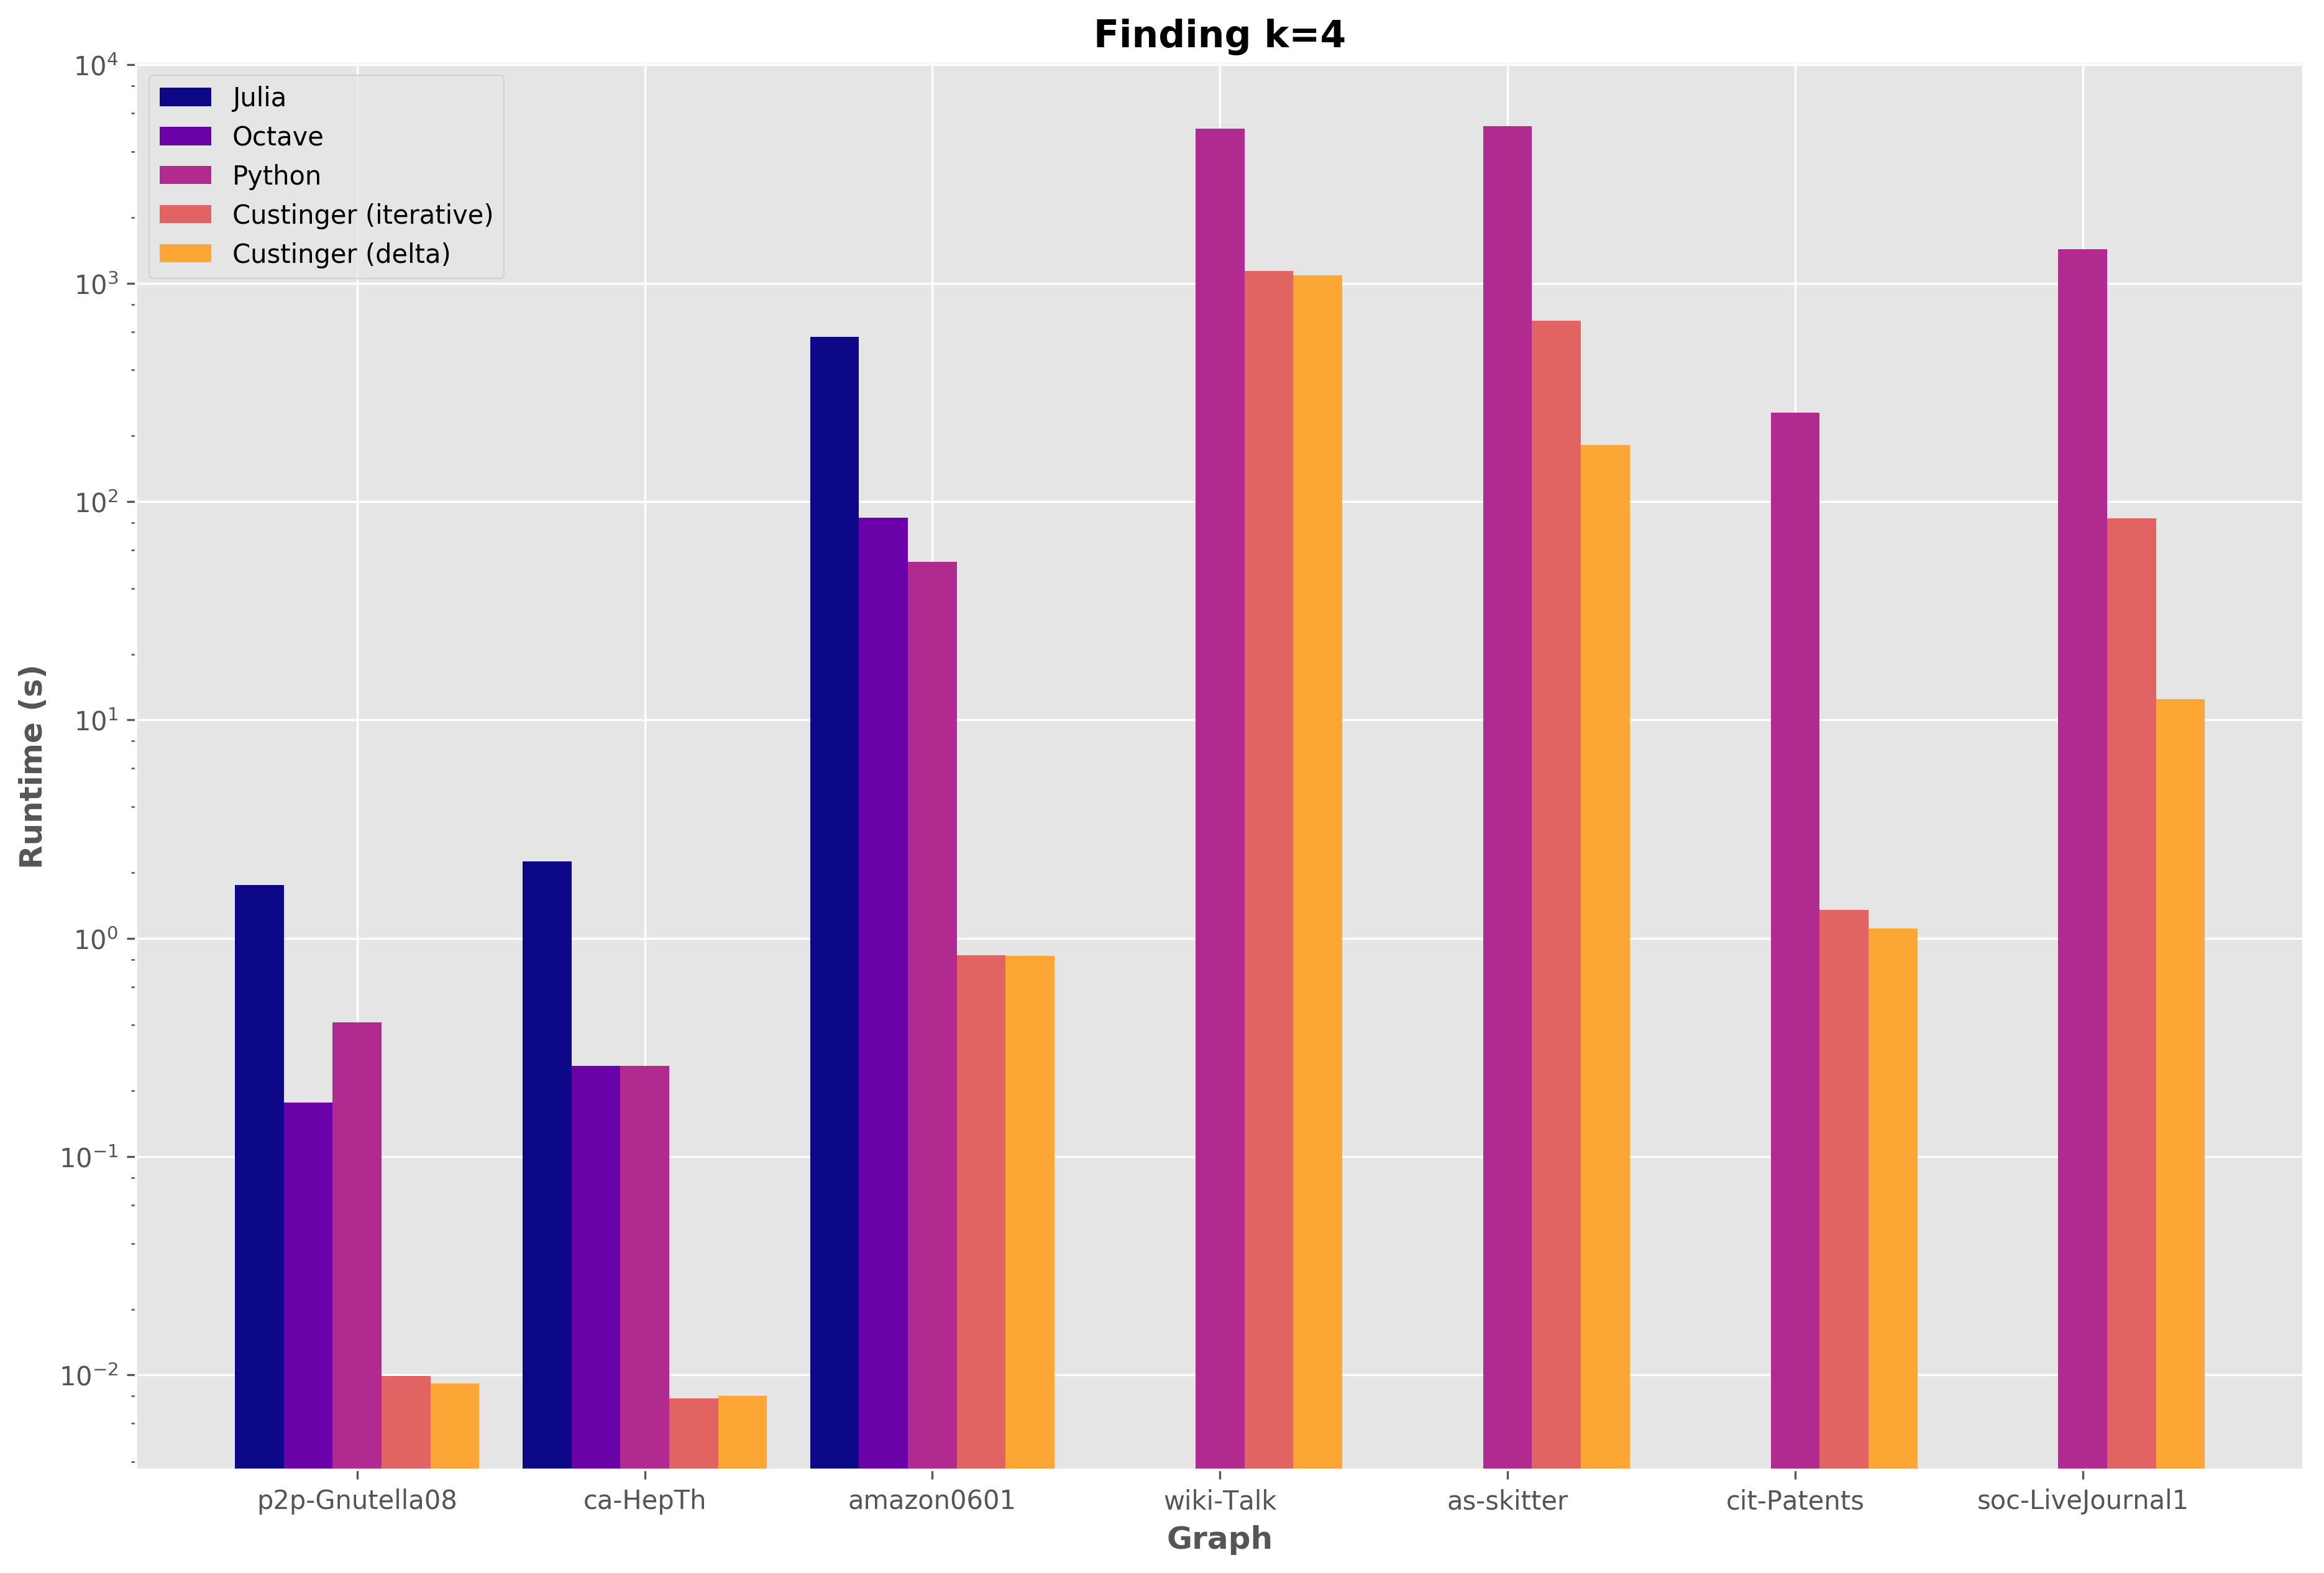

In [184]:
results = ["../results/julia-k4-061417.out", 
           "../results/matlab-k4-061417.out",
           "../results/python-k4-061417.out",
          "../results/static-k4-061417.out", 
            "../results/dynamic-k4-061617.out"]
benchmarks = ["Julia", "Octave", "Python", "Custinger (iterative)", "Custinger (delta)"]
graphs = ["p2p-Gnutella08","ca-HepTh","amazon0601","wiki-Talk","as-skitter", "cit-Patents", "soc-LiveJournal1"]
title = "Finding k=4"
saveTo = "../analysis/k4-barchart.png"
plotSingleKCompare(results, benchmarks, graphs, title, savePath=saveTo)

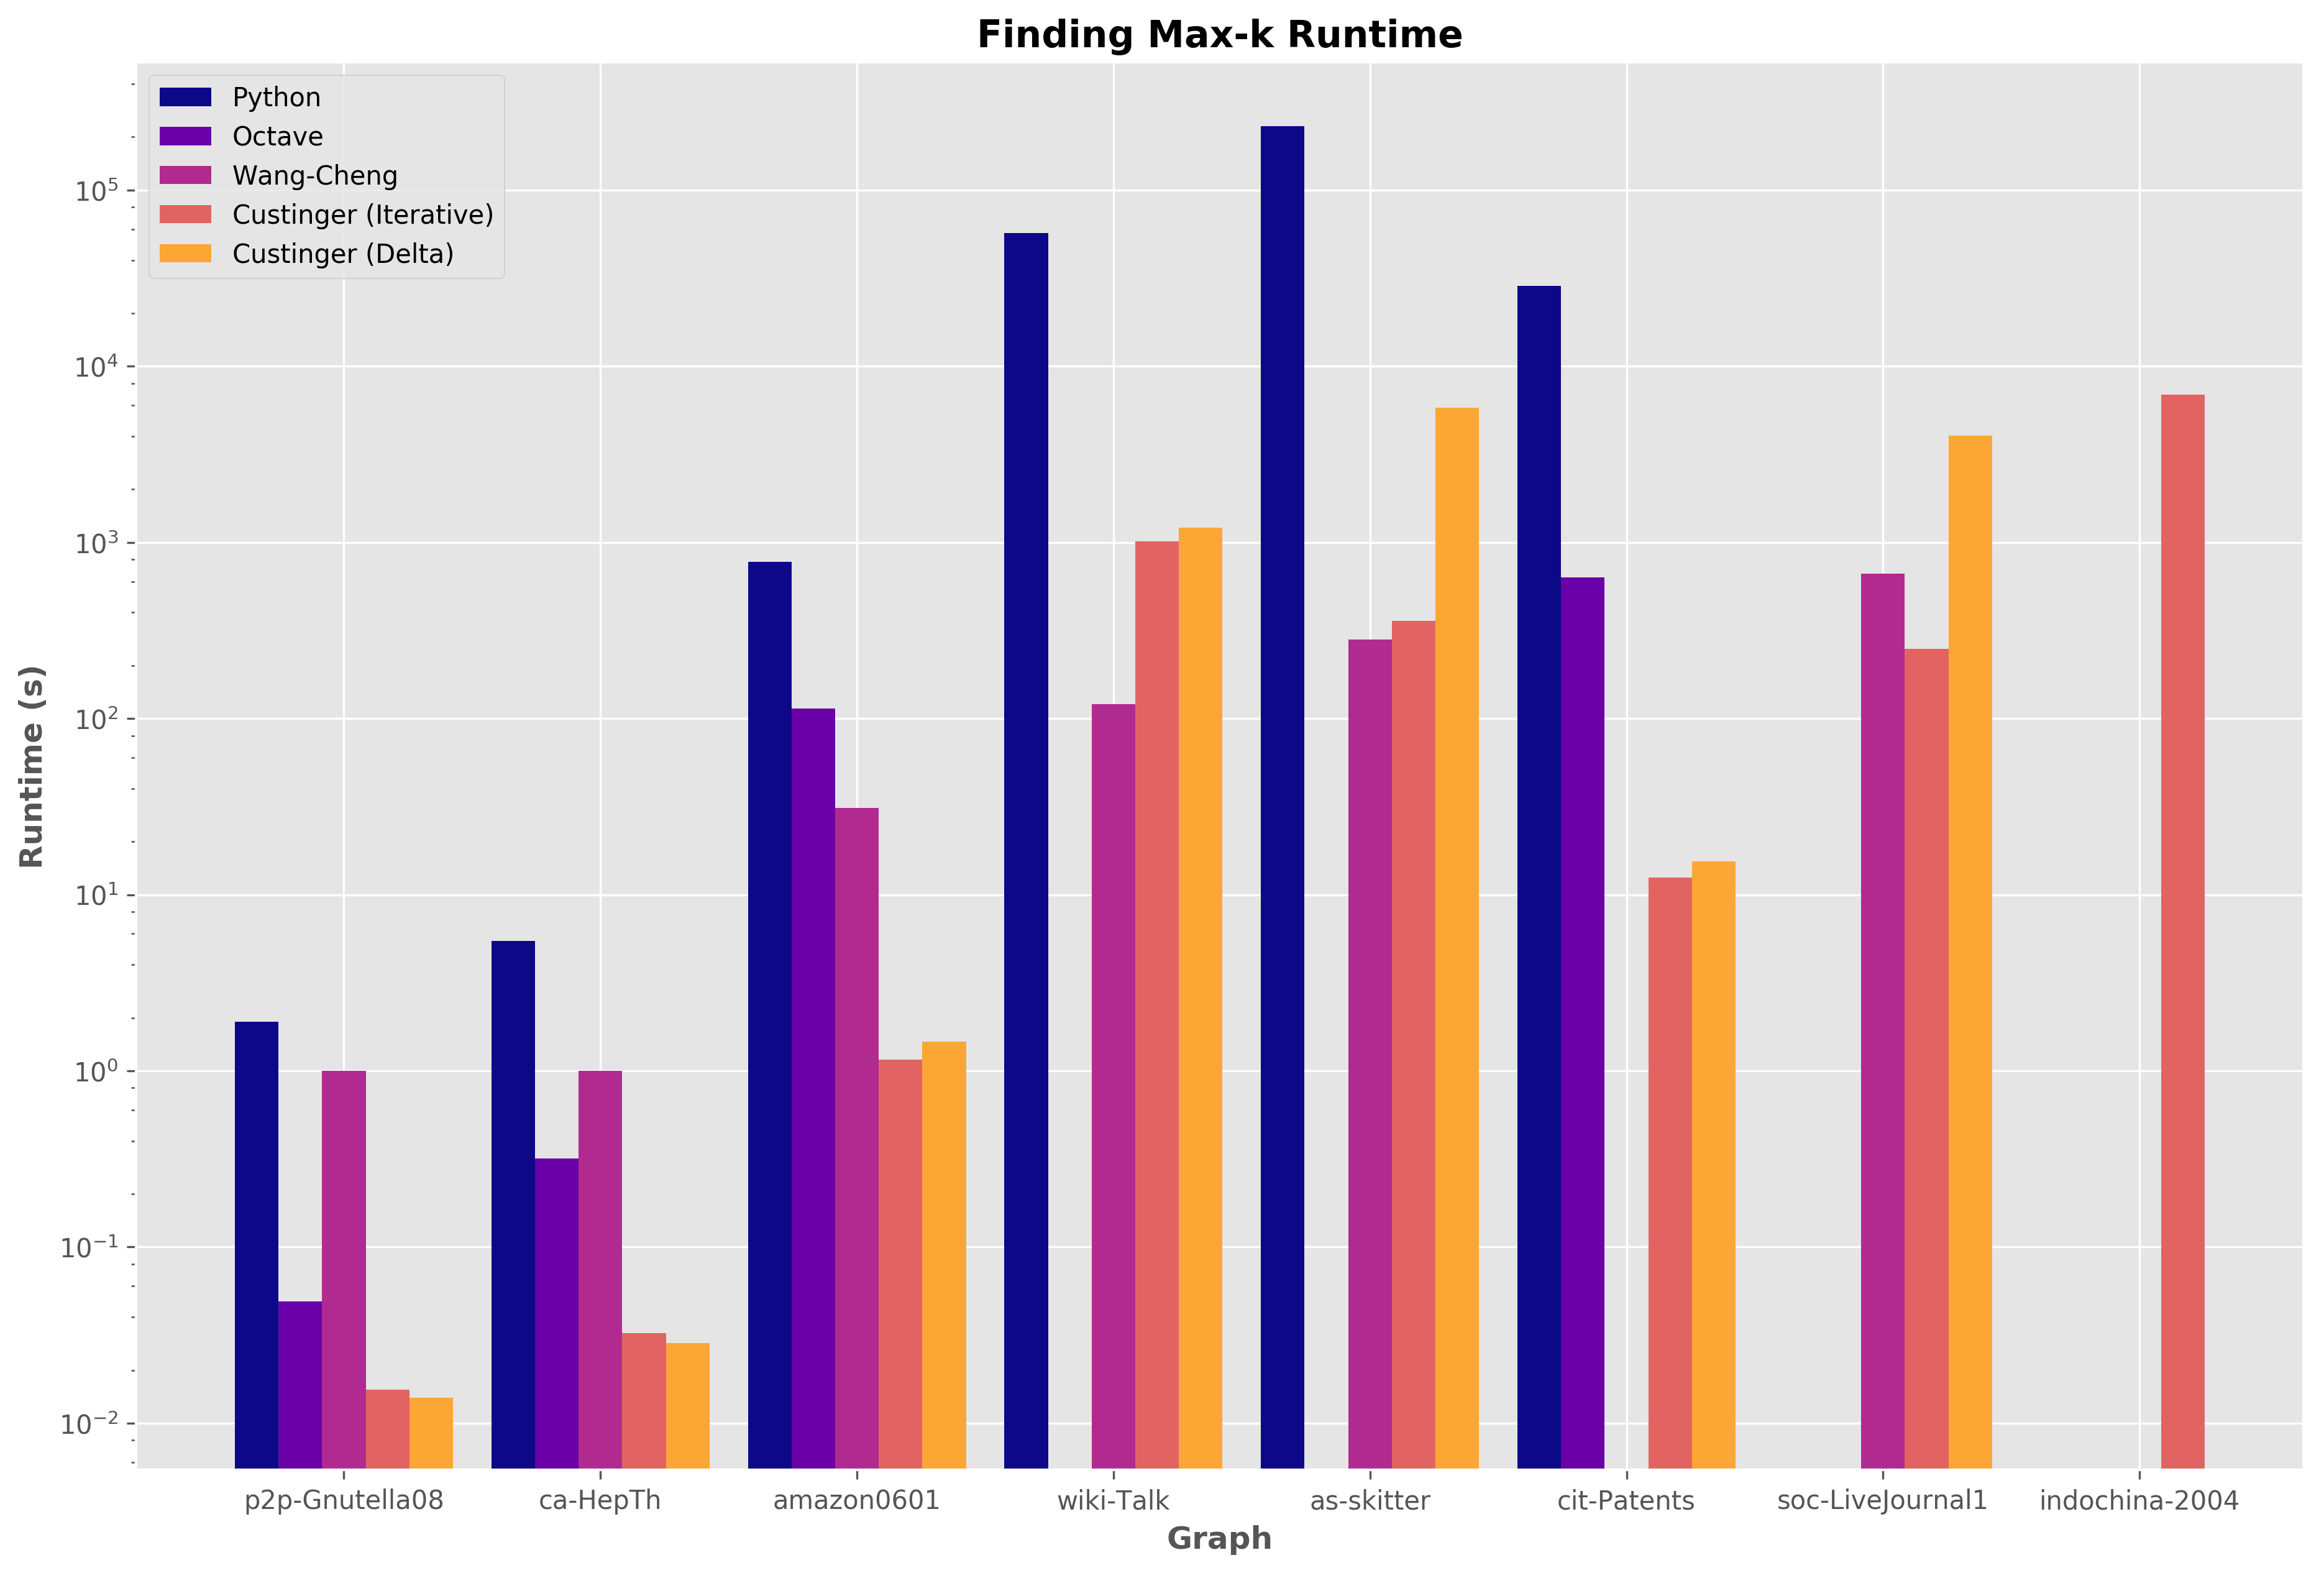

In [185]:
results = ["../results/python-maxk-061617.out",
           "../results/matlab-maxk-061917.out",
           "../results/Wang-Cheng-results.out", 
           "../results/custinger-dynamic-maxk-061317.out", 
          "../results/custinger-static-maxk-061417.out"]
benchmarks = ["Python", "Octave", "Wang-Cheng", "Custinger (Iterative)", "Custinger (Delta)"]
graphs = ["p2p-Gnutella08","ca-HepTh","amazon0601","wiki-Talk","as-skitter","cit-Patents","soc-LiveJournal1", "indochina-2004"]
title = "Finding Max-k Runtime"
saveTo = "../analysis/maxk-barchart.png"
plotSingleKCompare(results, benchmarks, graphs, title, savePath=saveTo)

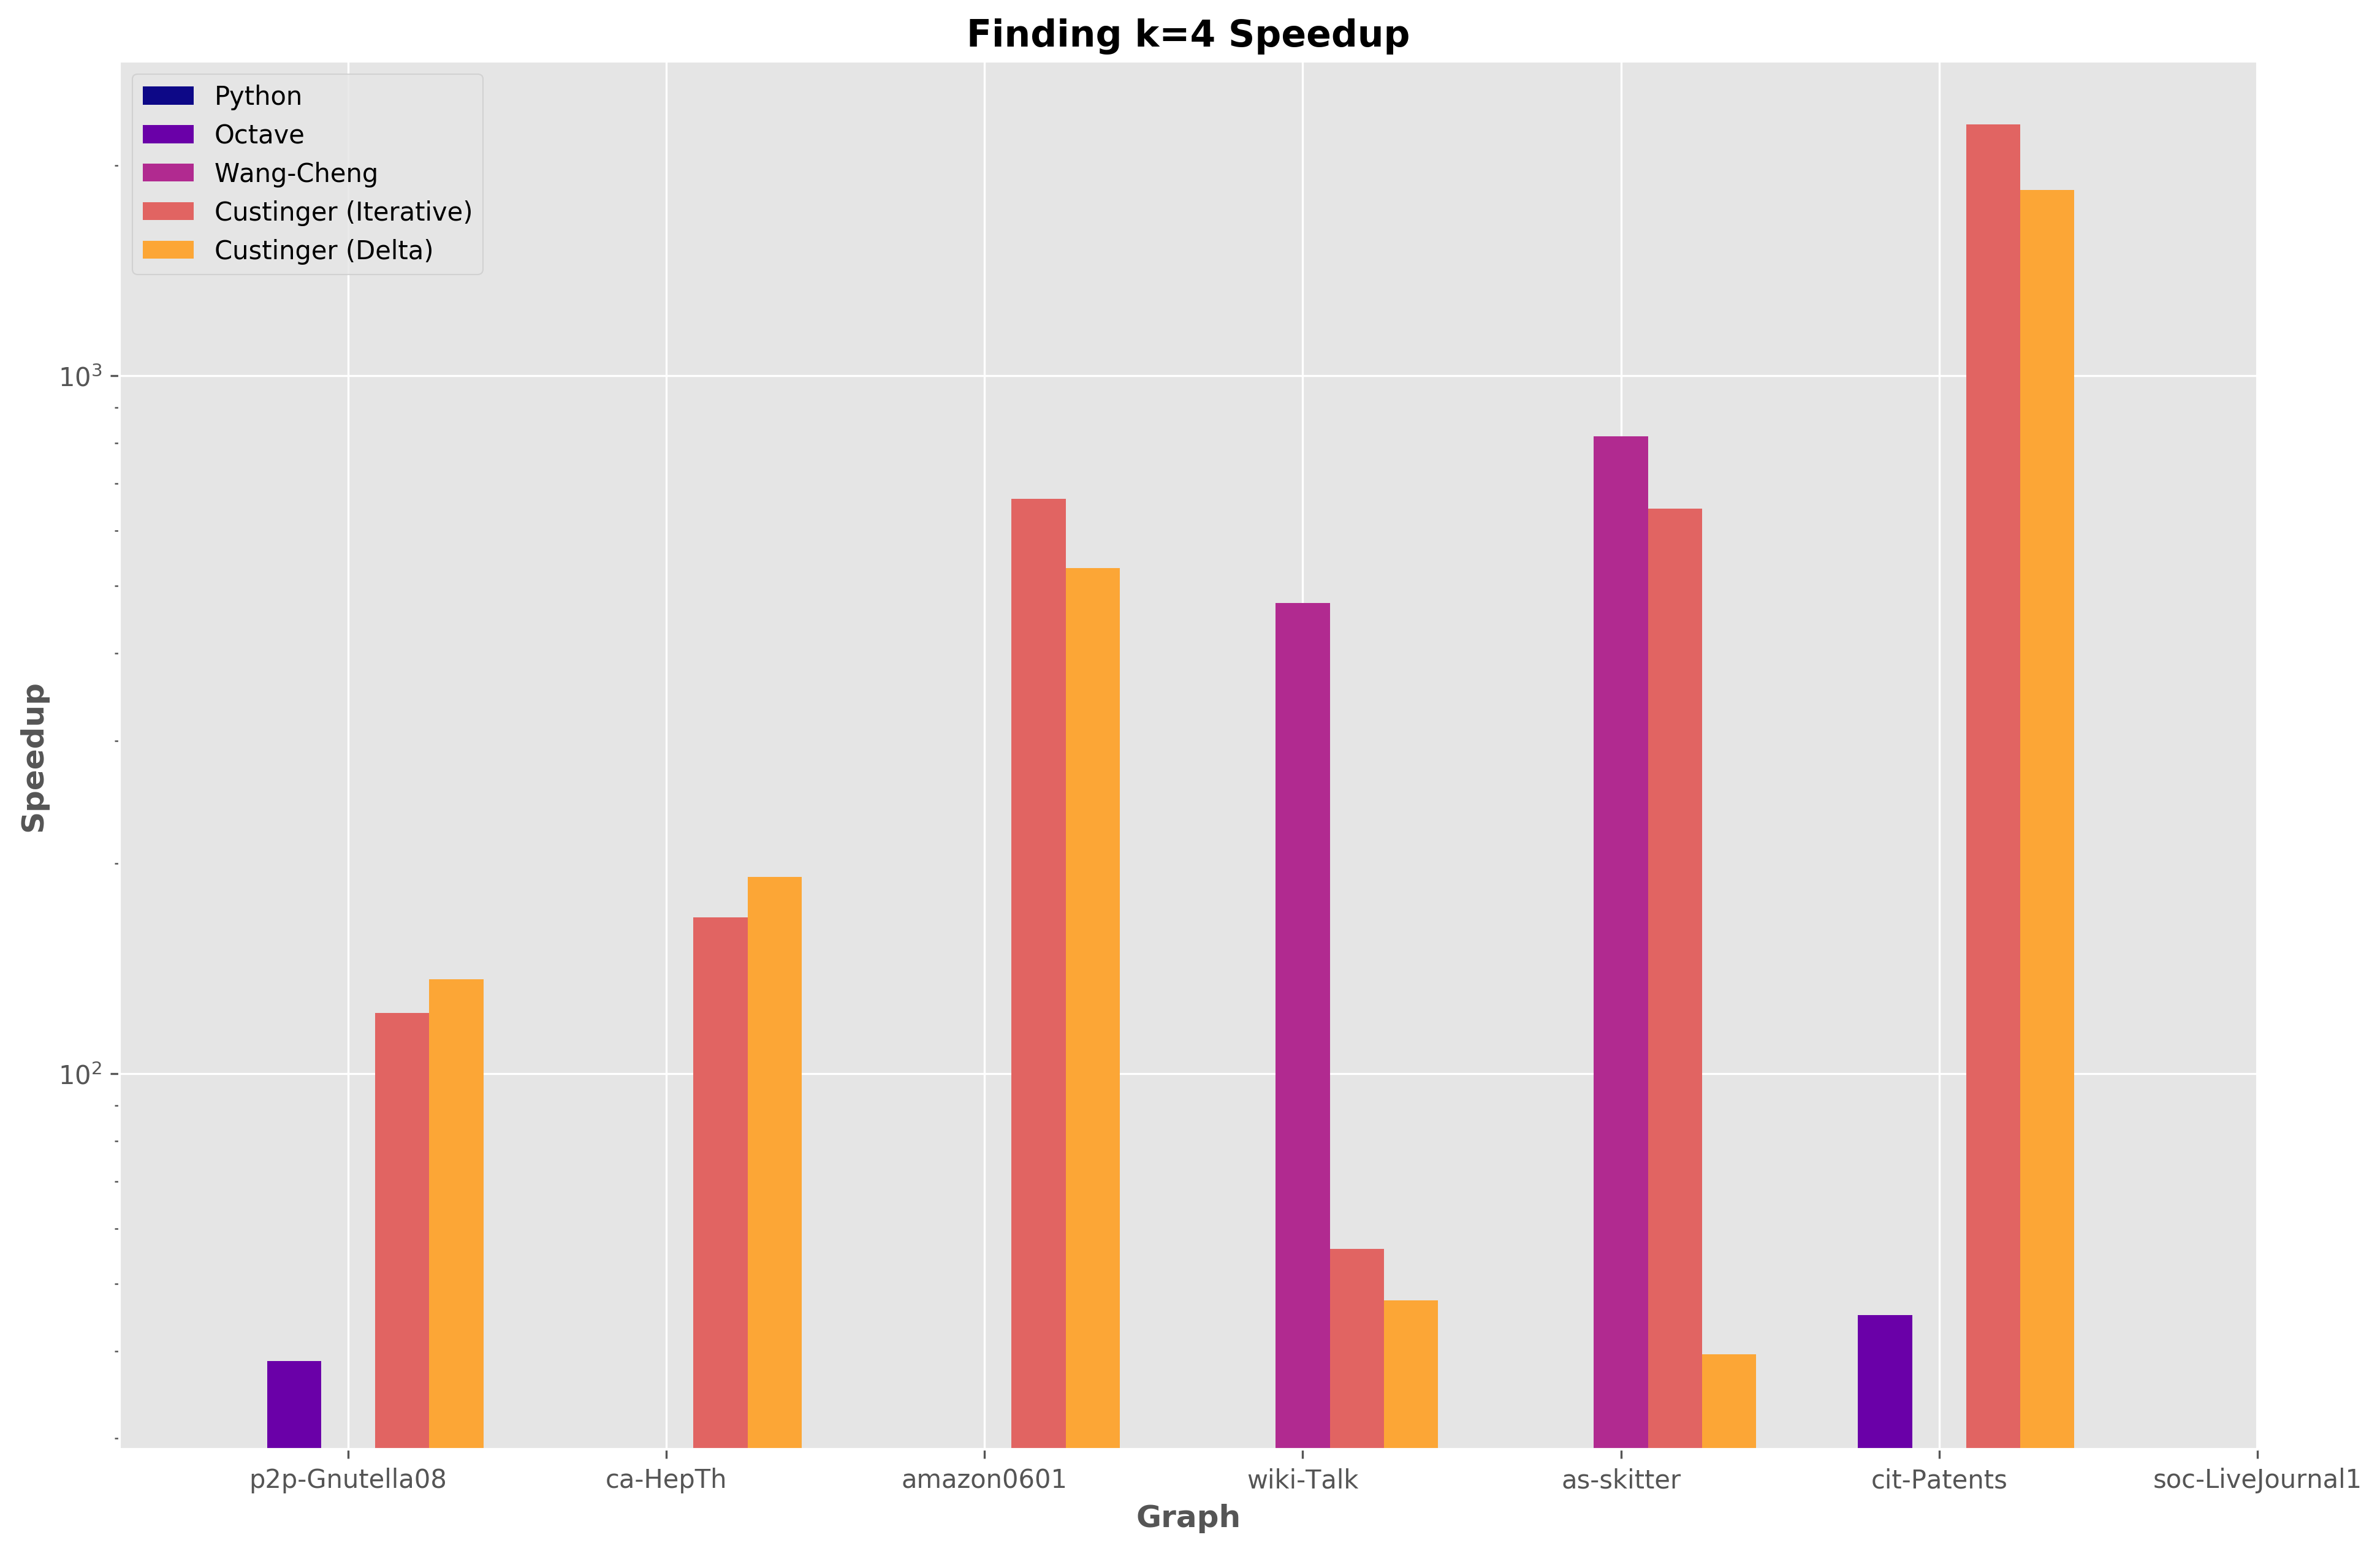

In [178]:
results = ["../results/python-maxk-061617.out",
           "../results/matlab-maxk-061917.out",
           "../results/Wang-Cheng-results.out", 
           "../results/custinger-dynamic-maxk-061317.out", 
          "../results/custinger-static-maxk-061417.out"]
benchmarks = ["Python", "Octave", "Wang-Cheng", "Custinger (Iterative)", "Custinger (Delta)"]
graphs = ["p2p-Gnutella08","ca-HepTh","amazon0601","wiki-Talk","as-skitter", "cit-Patents", "soc-LiveJournal1"]
title = "Finding k=4 Speedup"
saveTo = "../analysis/k4-speedup-comparison.png"
plotSingleKCompareSpeedup(results, benchmarks, graphs, title, savePath=saveTo)

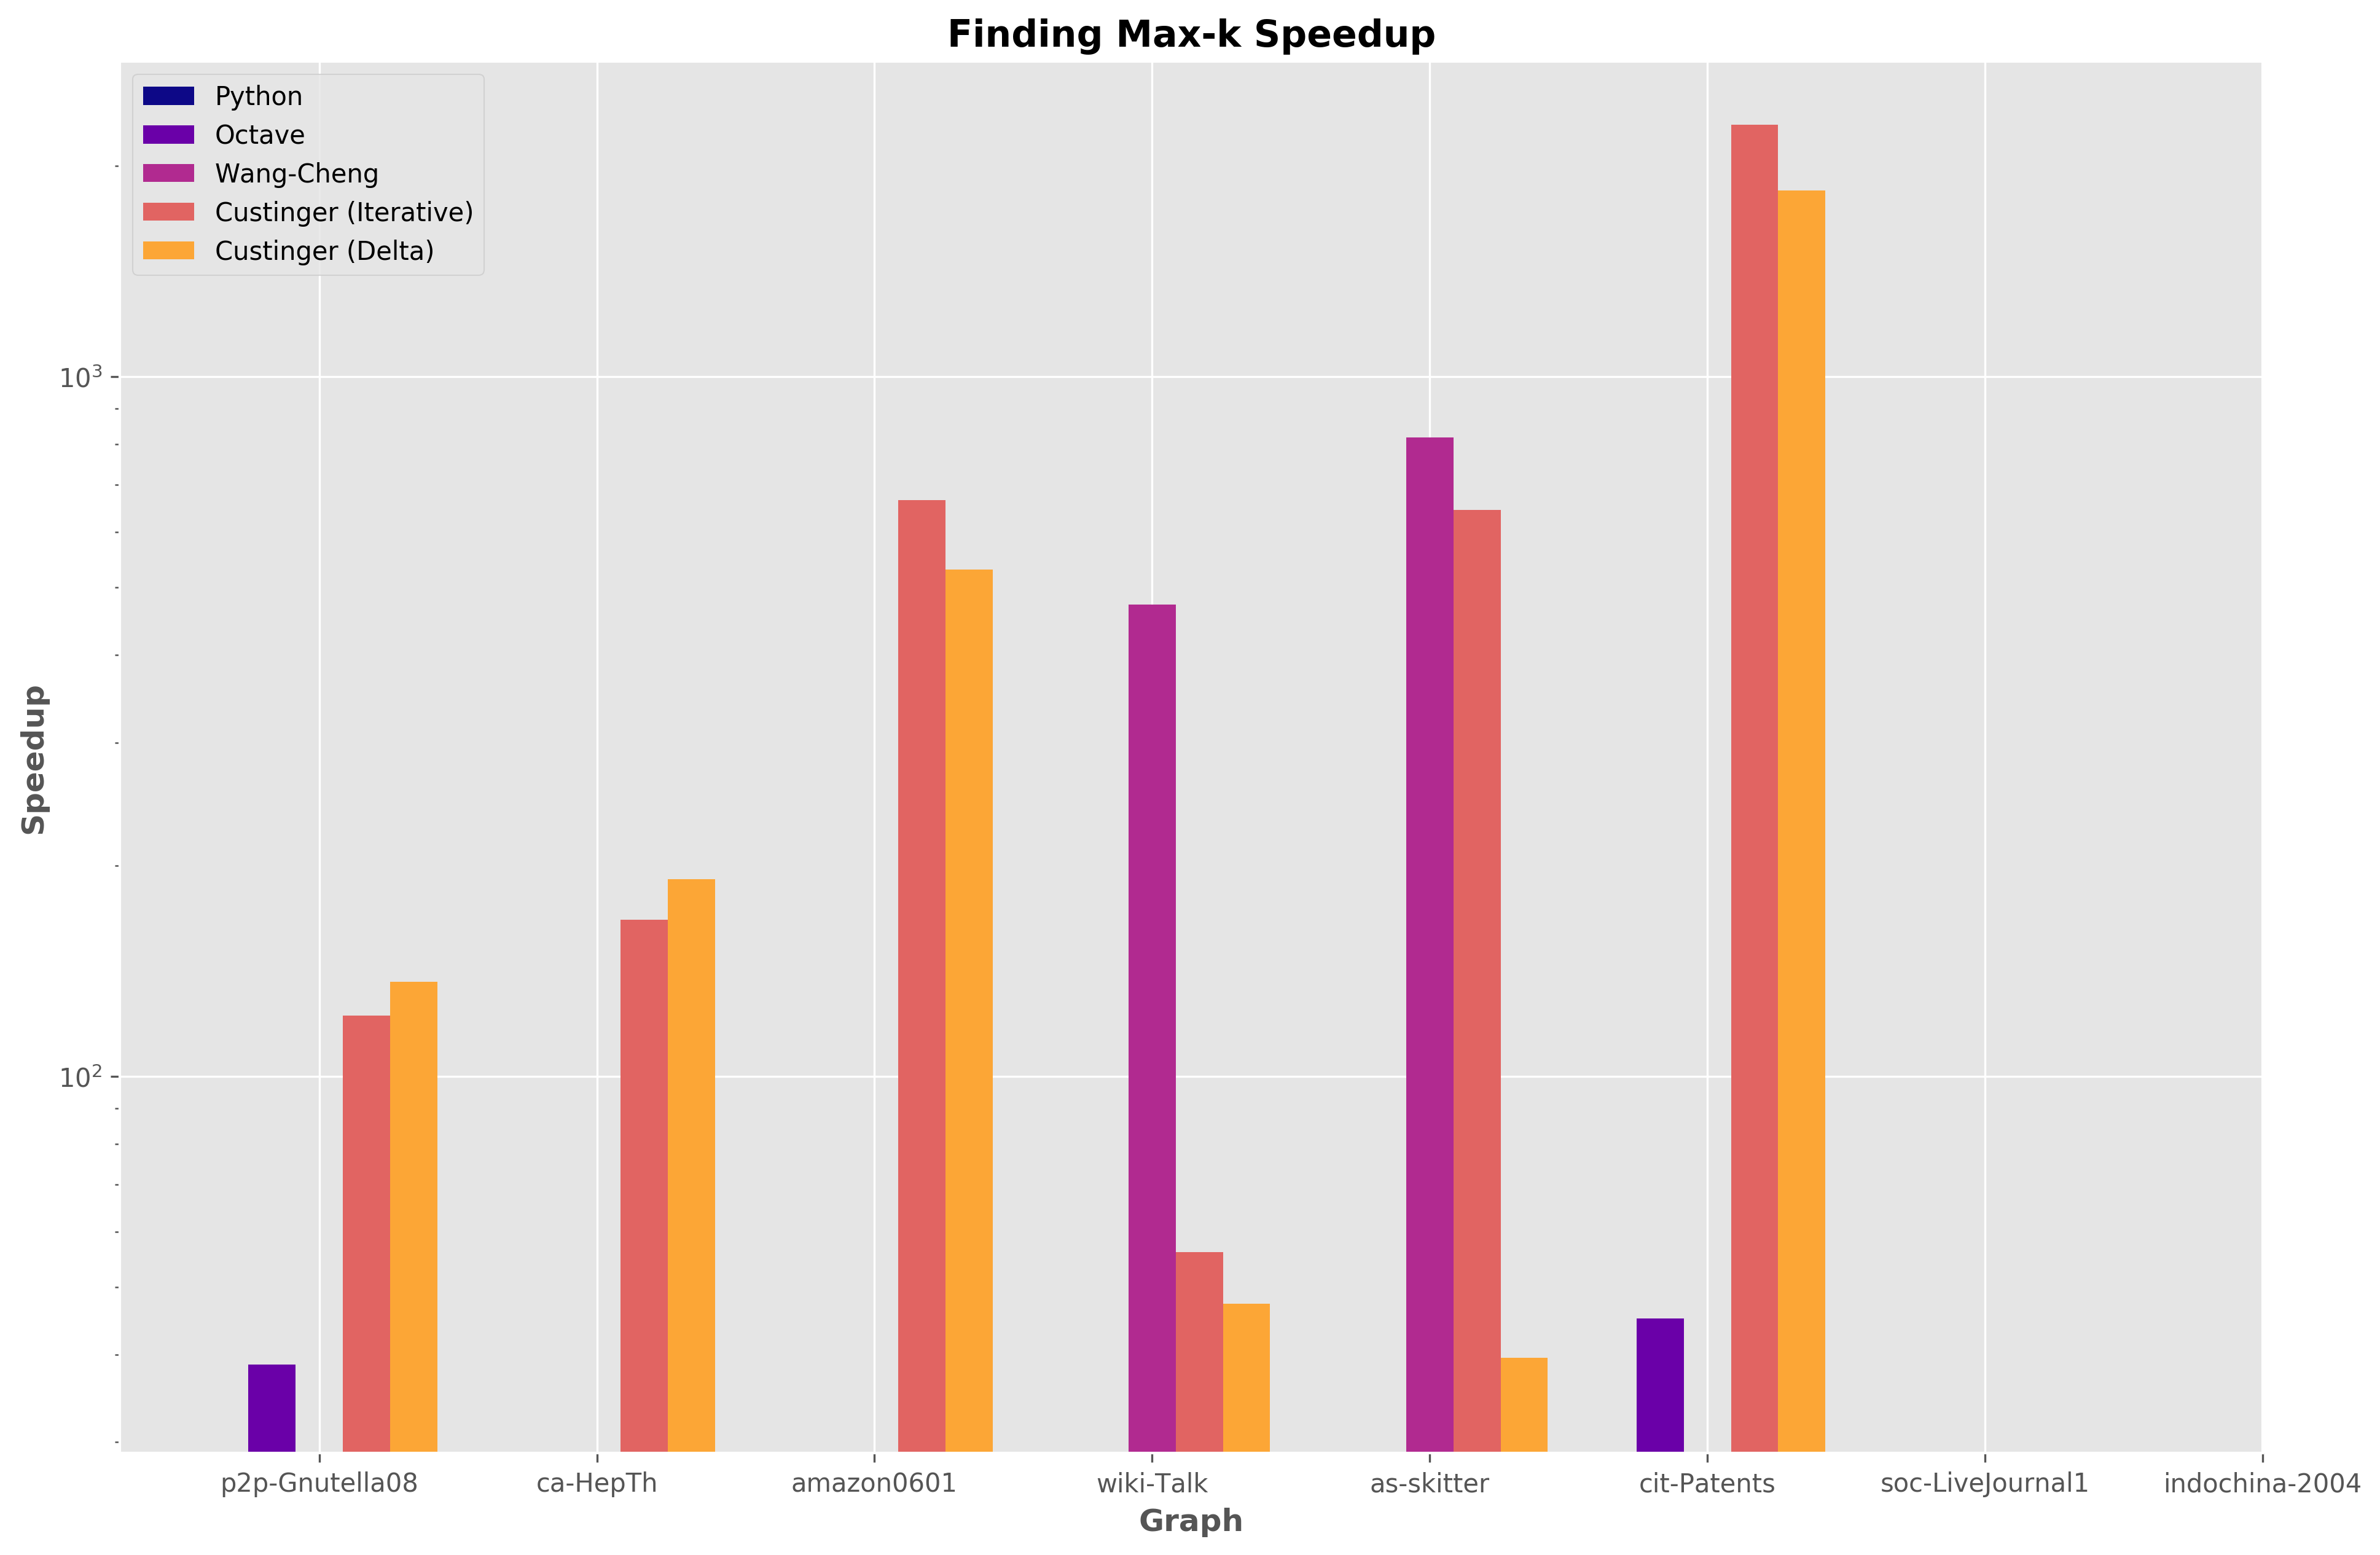

In [186]:
results = ["../results/python-maxk-061617.out",
           "../results/matlab-maxk-061917.out",
           "../results/Wang-Cheng-results.out", 
           "../results/custinger-dynamic-maxk-061317.out", 
          "../results/custinger-static-maxk-061417.out"]
benchmarks = ["Python", "Octave", "Wang-Cheng", "Custinger (Iterative)", "Custinger (Delta)"]
graphs = ["p2p-Gnutella08","ca-HepTh","amazon0601","wiki-Talk","as-skitter","cit-Patents","soc-LiveJournal1", "indochina-2004"]
title = "Finding Max-k Speedup"
saveTo = "../analysis/maxk-speedup-barchart.png"
plotSingleKCompareSpeedup(results, benchmarks, graphs, title, savePath=saveTo)

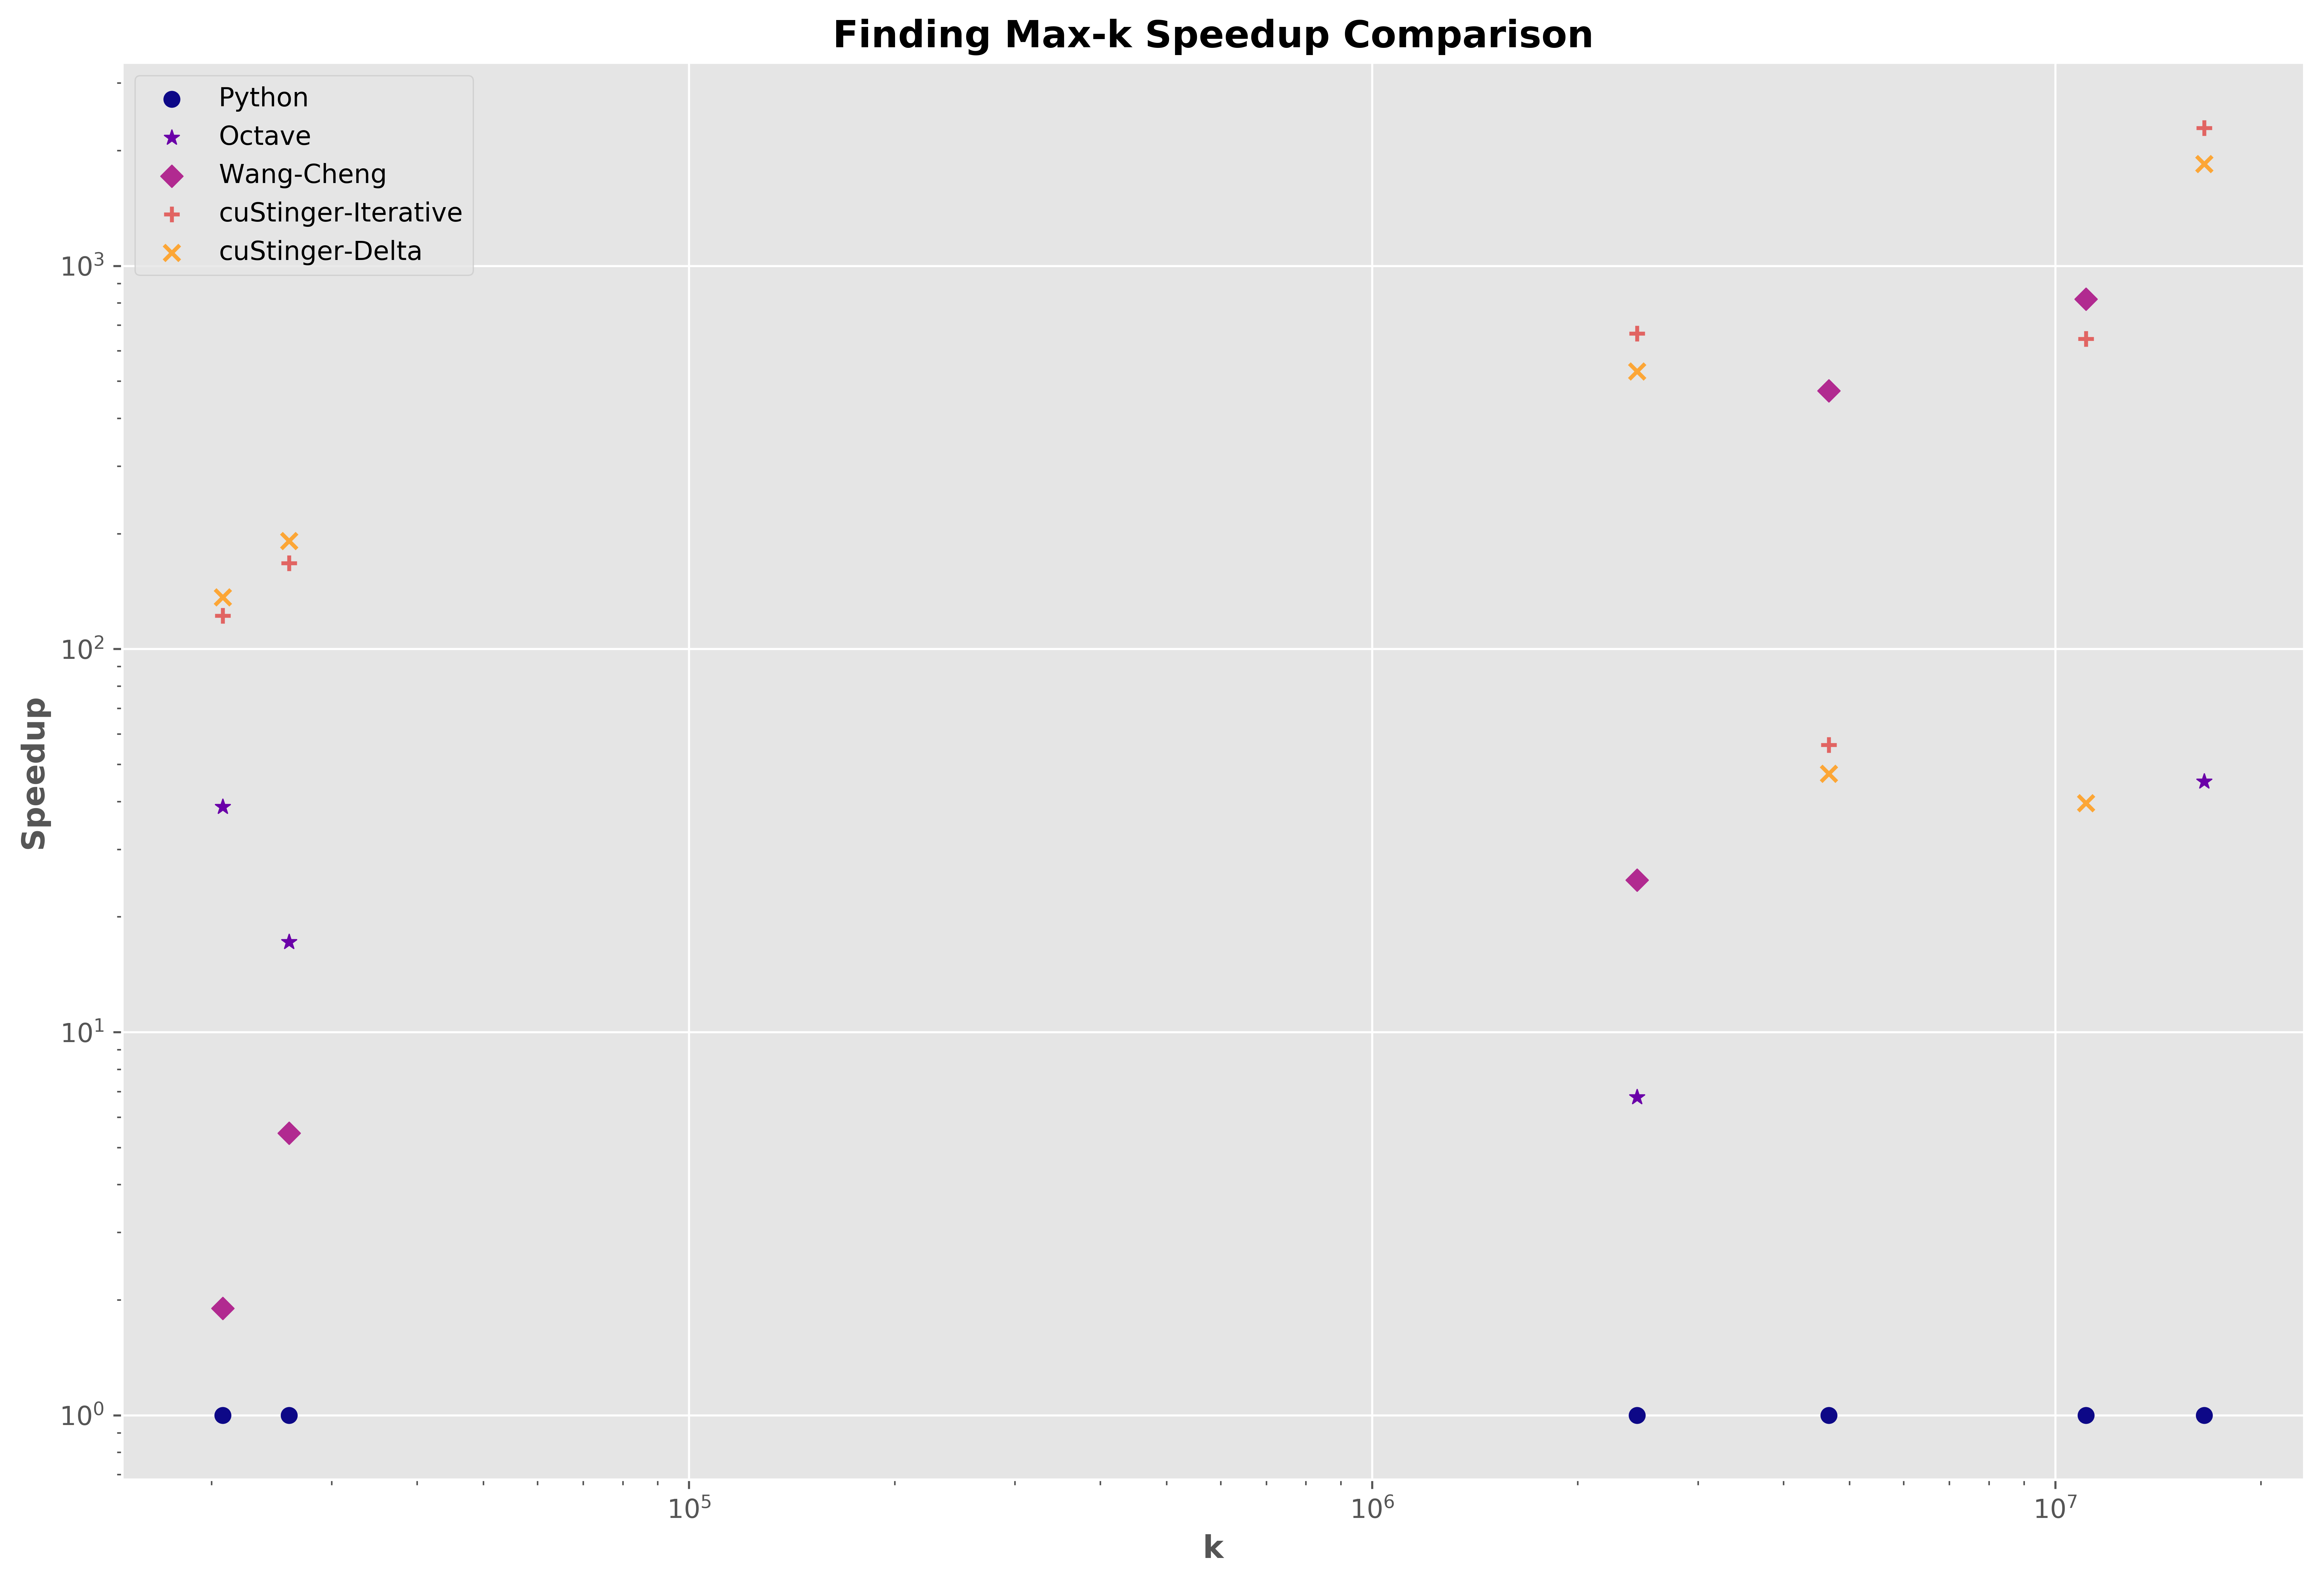

In [187]:
results = ["../results/python-maxk-061617.out",
           "../results/matlab-maxk-061917.out",
           "../results/Wang-Cheng-results.out", 
           "../results/custinger-dynamic-maxk-061317.out", 
          "../results/custinger-static-maxk-061417.out"]
benchmarks = ["Python", "Octave", WC, CUS1, CUS2]
graphs = ["p2p-Gnutella08","ca-HepTh","amazon0601","wiki-Talk","as-skitter","cit-Patents","soc-LiveJournal1", "indochina-2004"]
title = "Finding Max-k Speedup Comparison"
saveTo = "../analysis/maxk-speedup-scatter.png"
plotKCompareSpeedupScatter(results, benchmarks, graphs, title, savePath=saveTo)

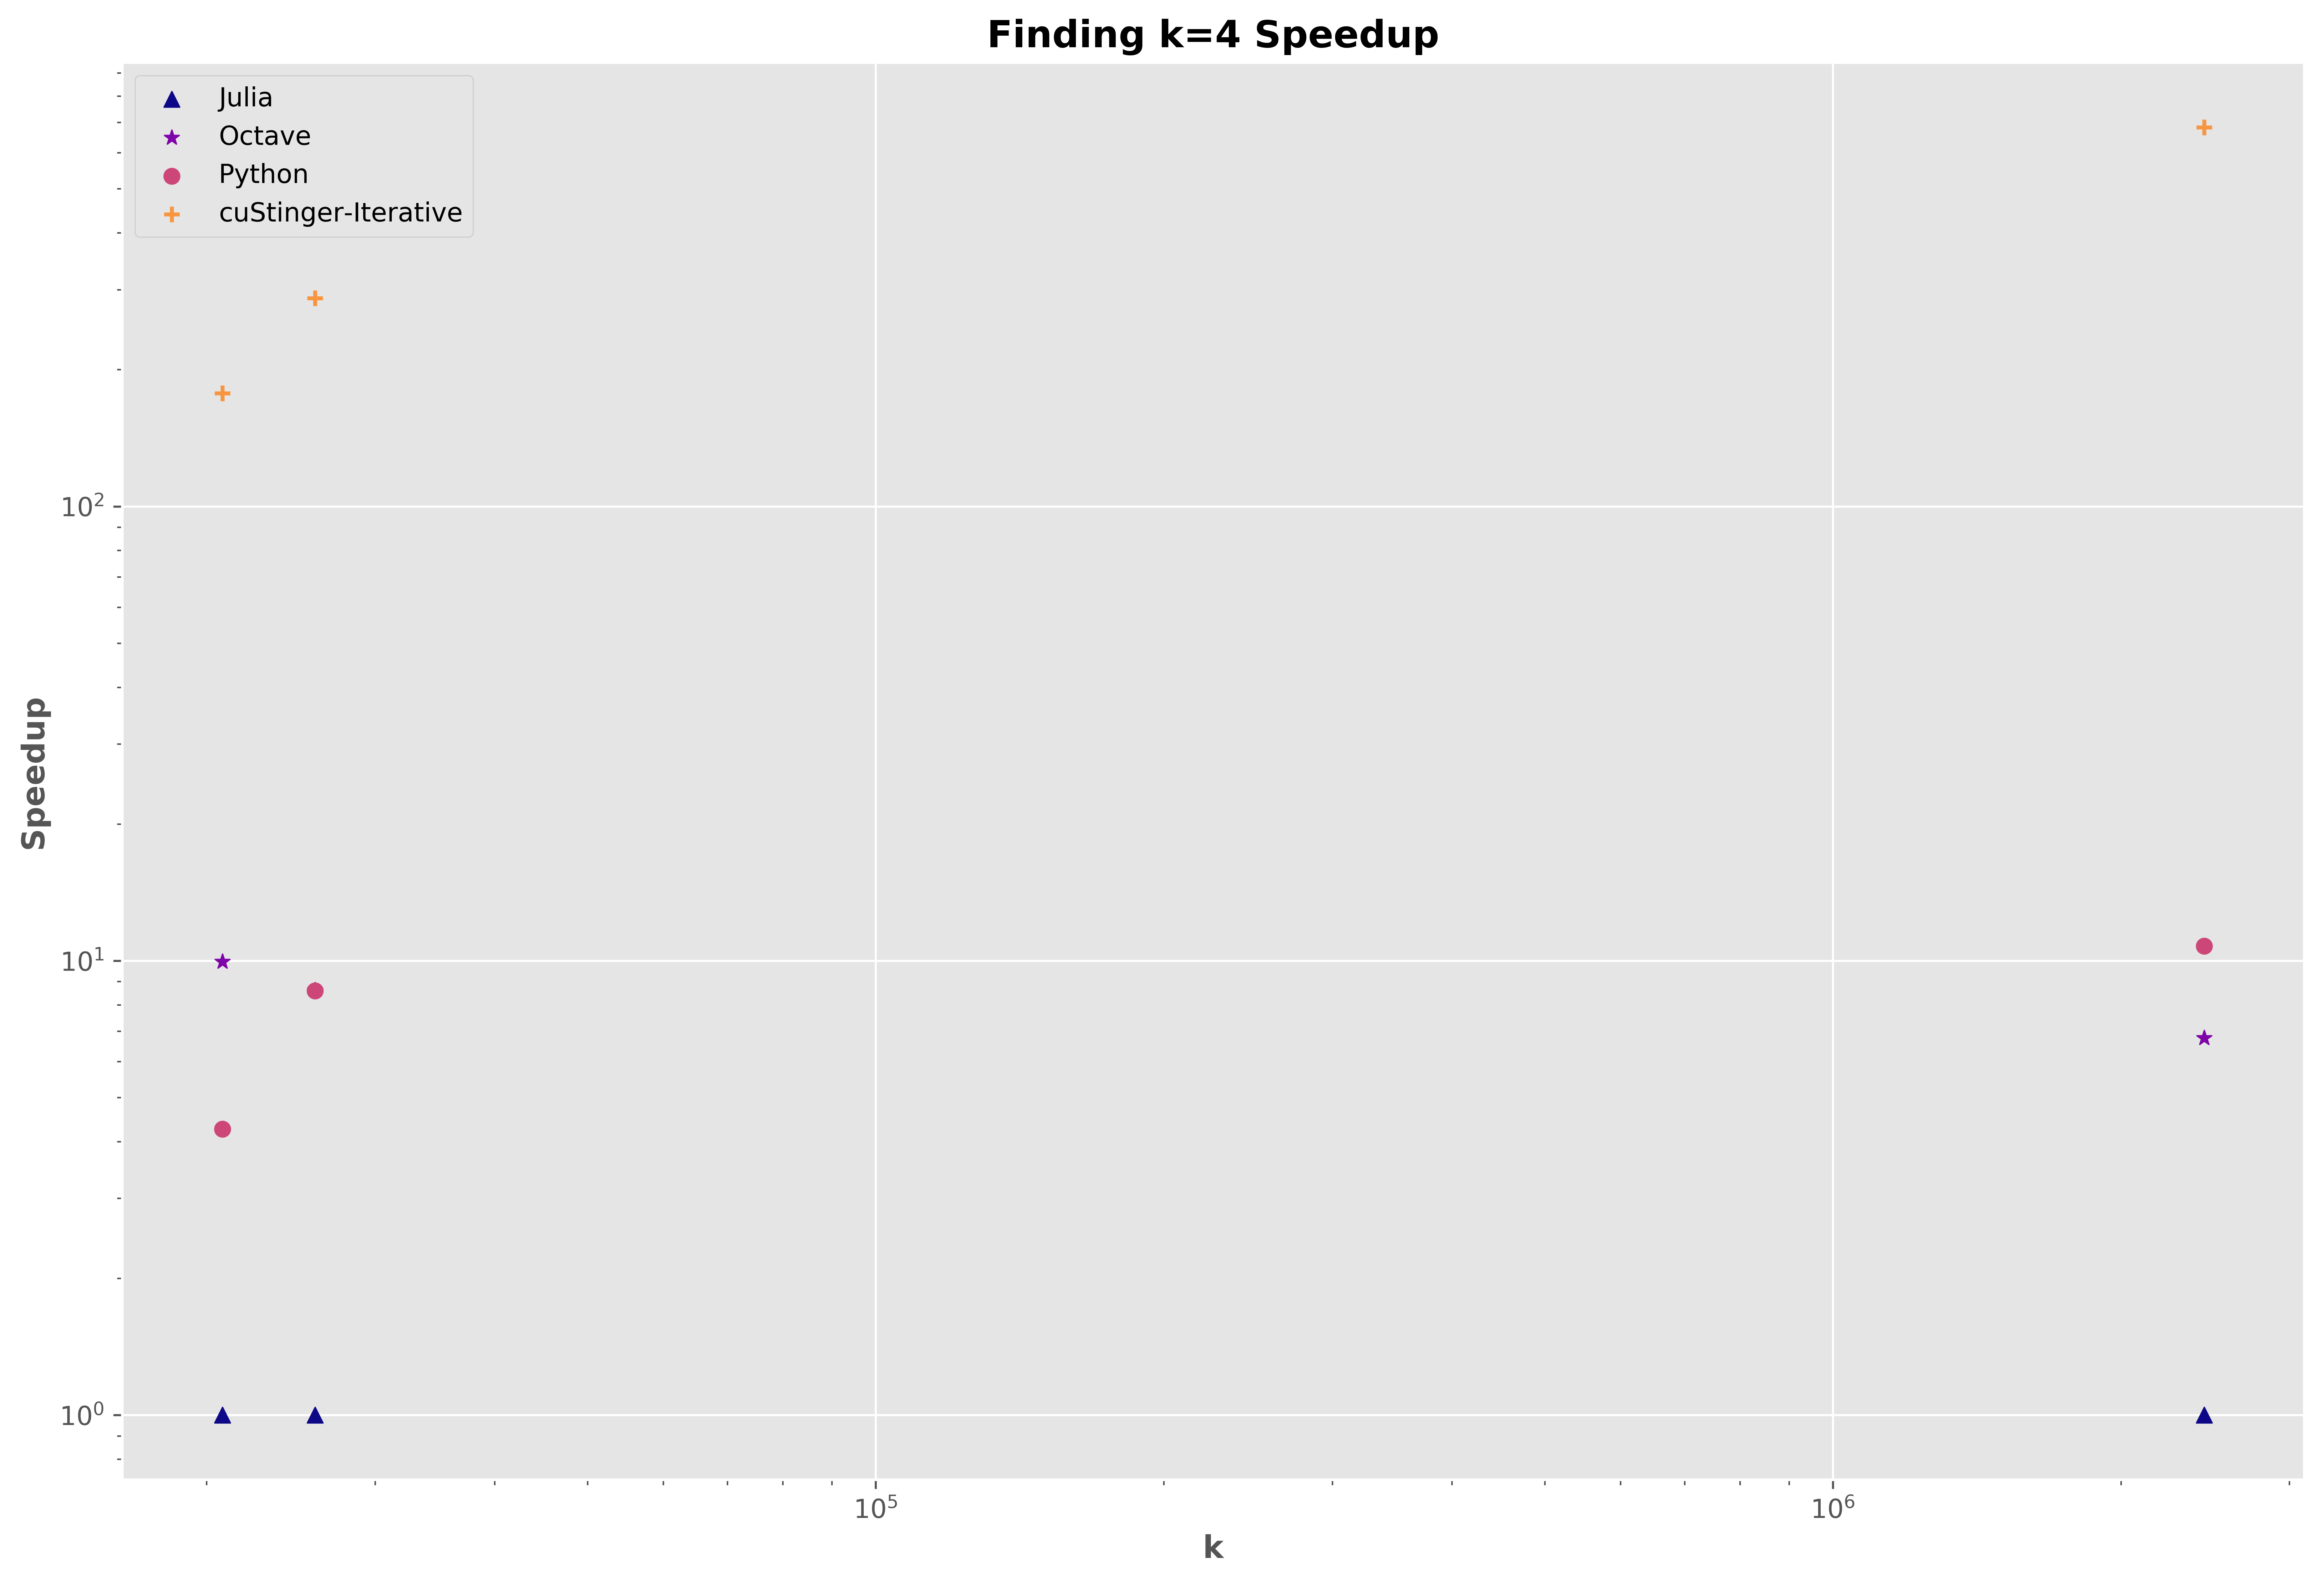

In [188]:
results = ["../results/julia-k4-061417.out", 
           "../results/matlab-k4-061417.out",
           "../results/python-k4-061417.out",
          "../results/static-k4-061417.out"]
benchmarks = ["Julia", "Octave", "Python", CUS1]
graphs = ["p2p-Gnutella08","ca-HepTh","amazon0601","wiki-Talk","as-skitter", "cit-Patents", "soc-LiveJournal1"]
title = "Finding k=4 Speedup"
saveTo = "../analysis/k4-speedup-scatter.png"
plotKCompareSpeedupScatter(results, benchmarks, graphs, title, savePath=saveTo)

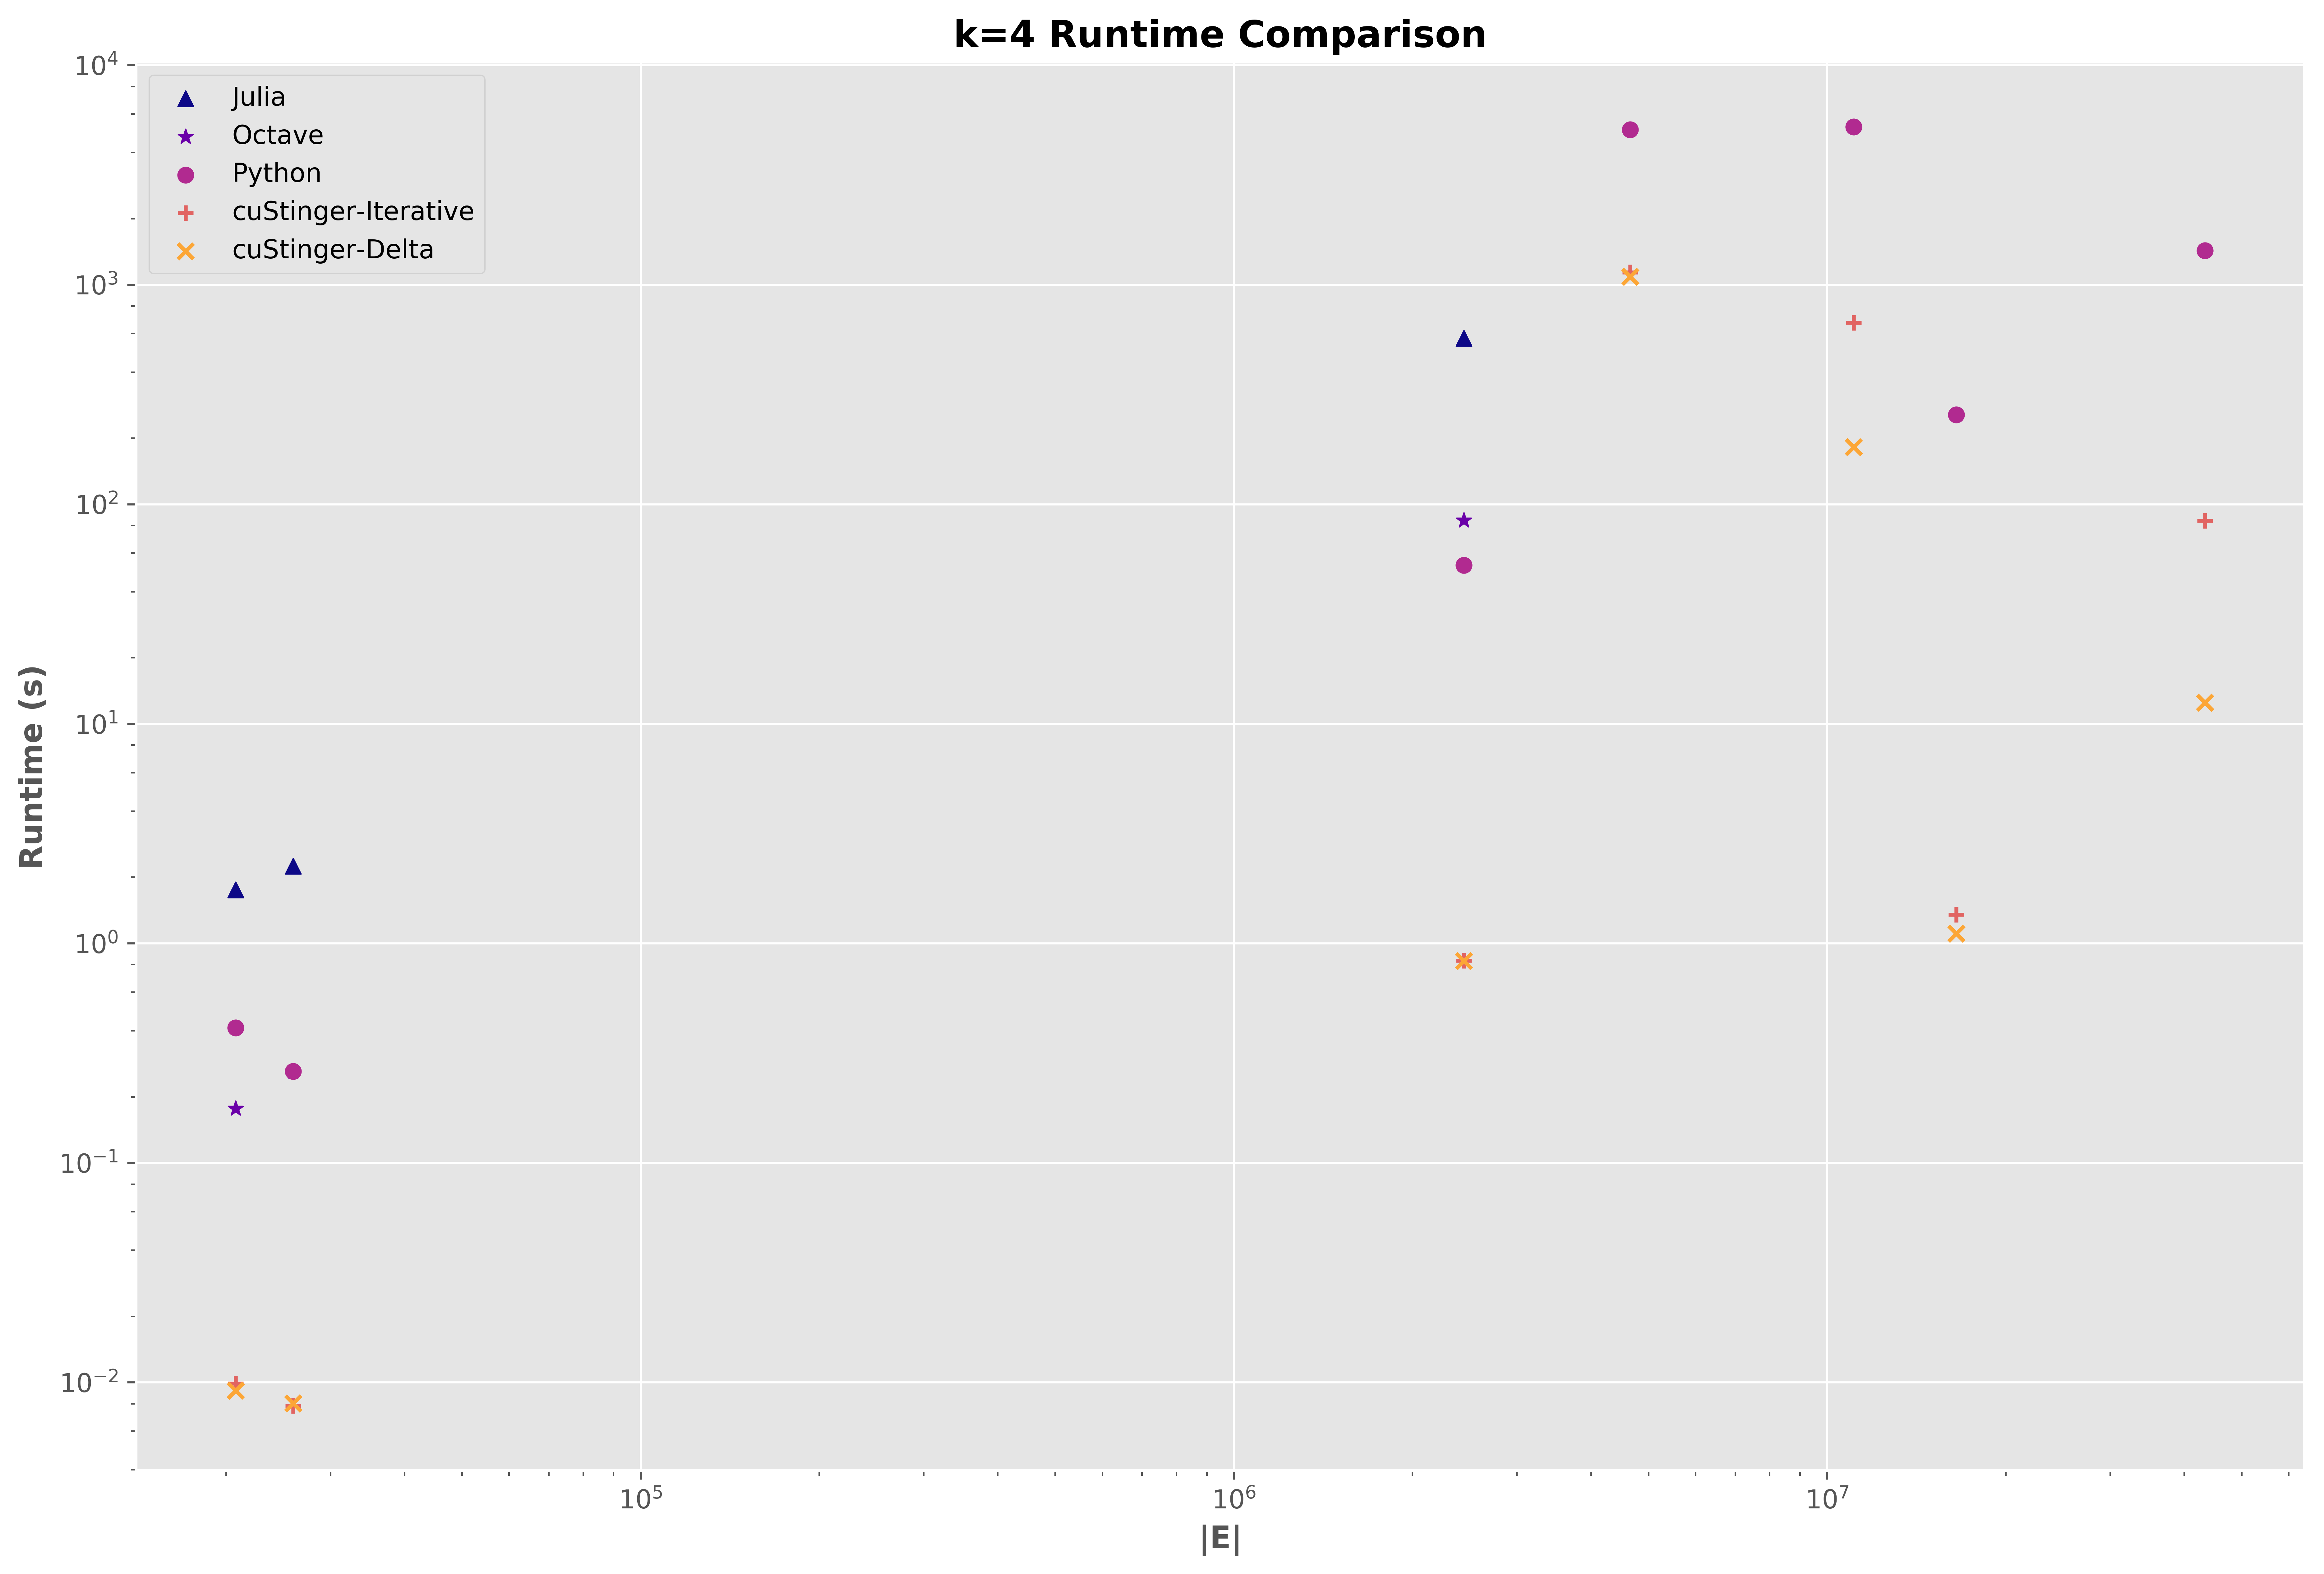

In [190]:
results = ["../results/julia-k4-061417.out", 
           "../results/matlab-k4-061417.out",
           "../results/python-k4-061417.out",
          "../results/static-k4-061417.out",
          "../results/dynamic-k4-061617.out"]
benchmarks = ["Julia", "Octave", "Python", CUS1, CUS2]
graphs = ["p2p-Gnutella08","ca-HepTh","amazon0601","wiki-Talk","as-skitter", "cit-Patents", "soc-LiveJournal1"]
title = "k=4 Runtime Comparison"
saveTo = "../analysis/k4-scatter.png"
plotKCompareScatter(results, benchmarks, graphs, title, savePath=saveTo)

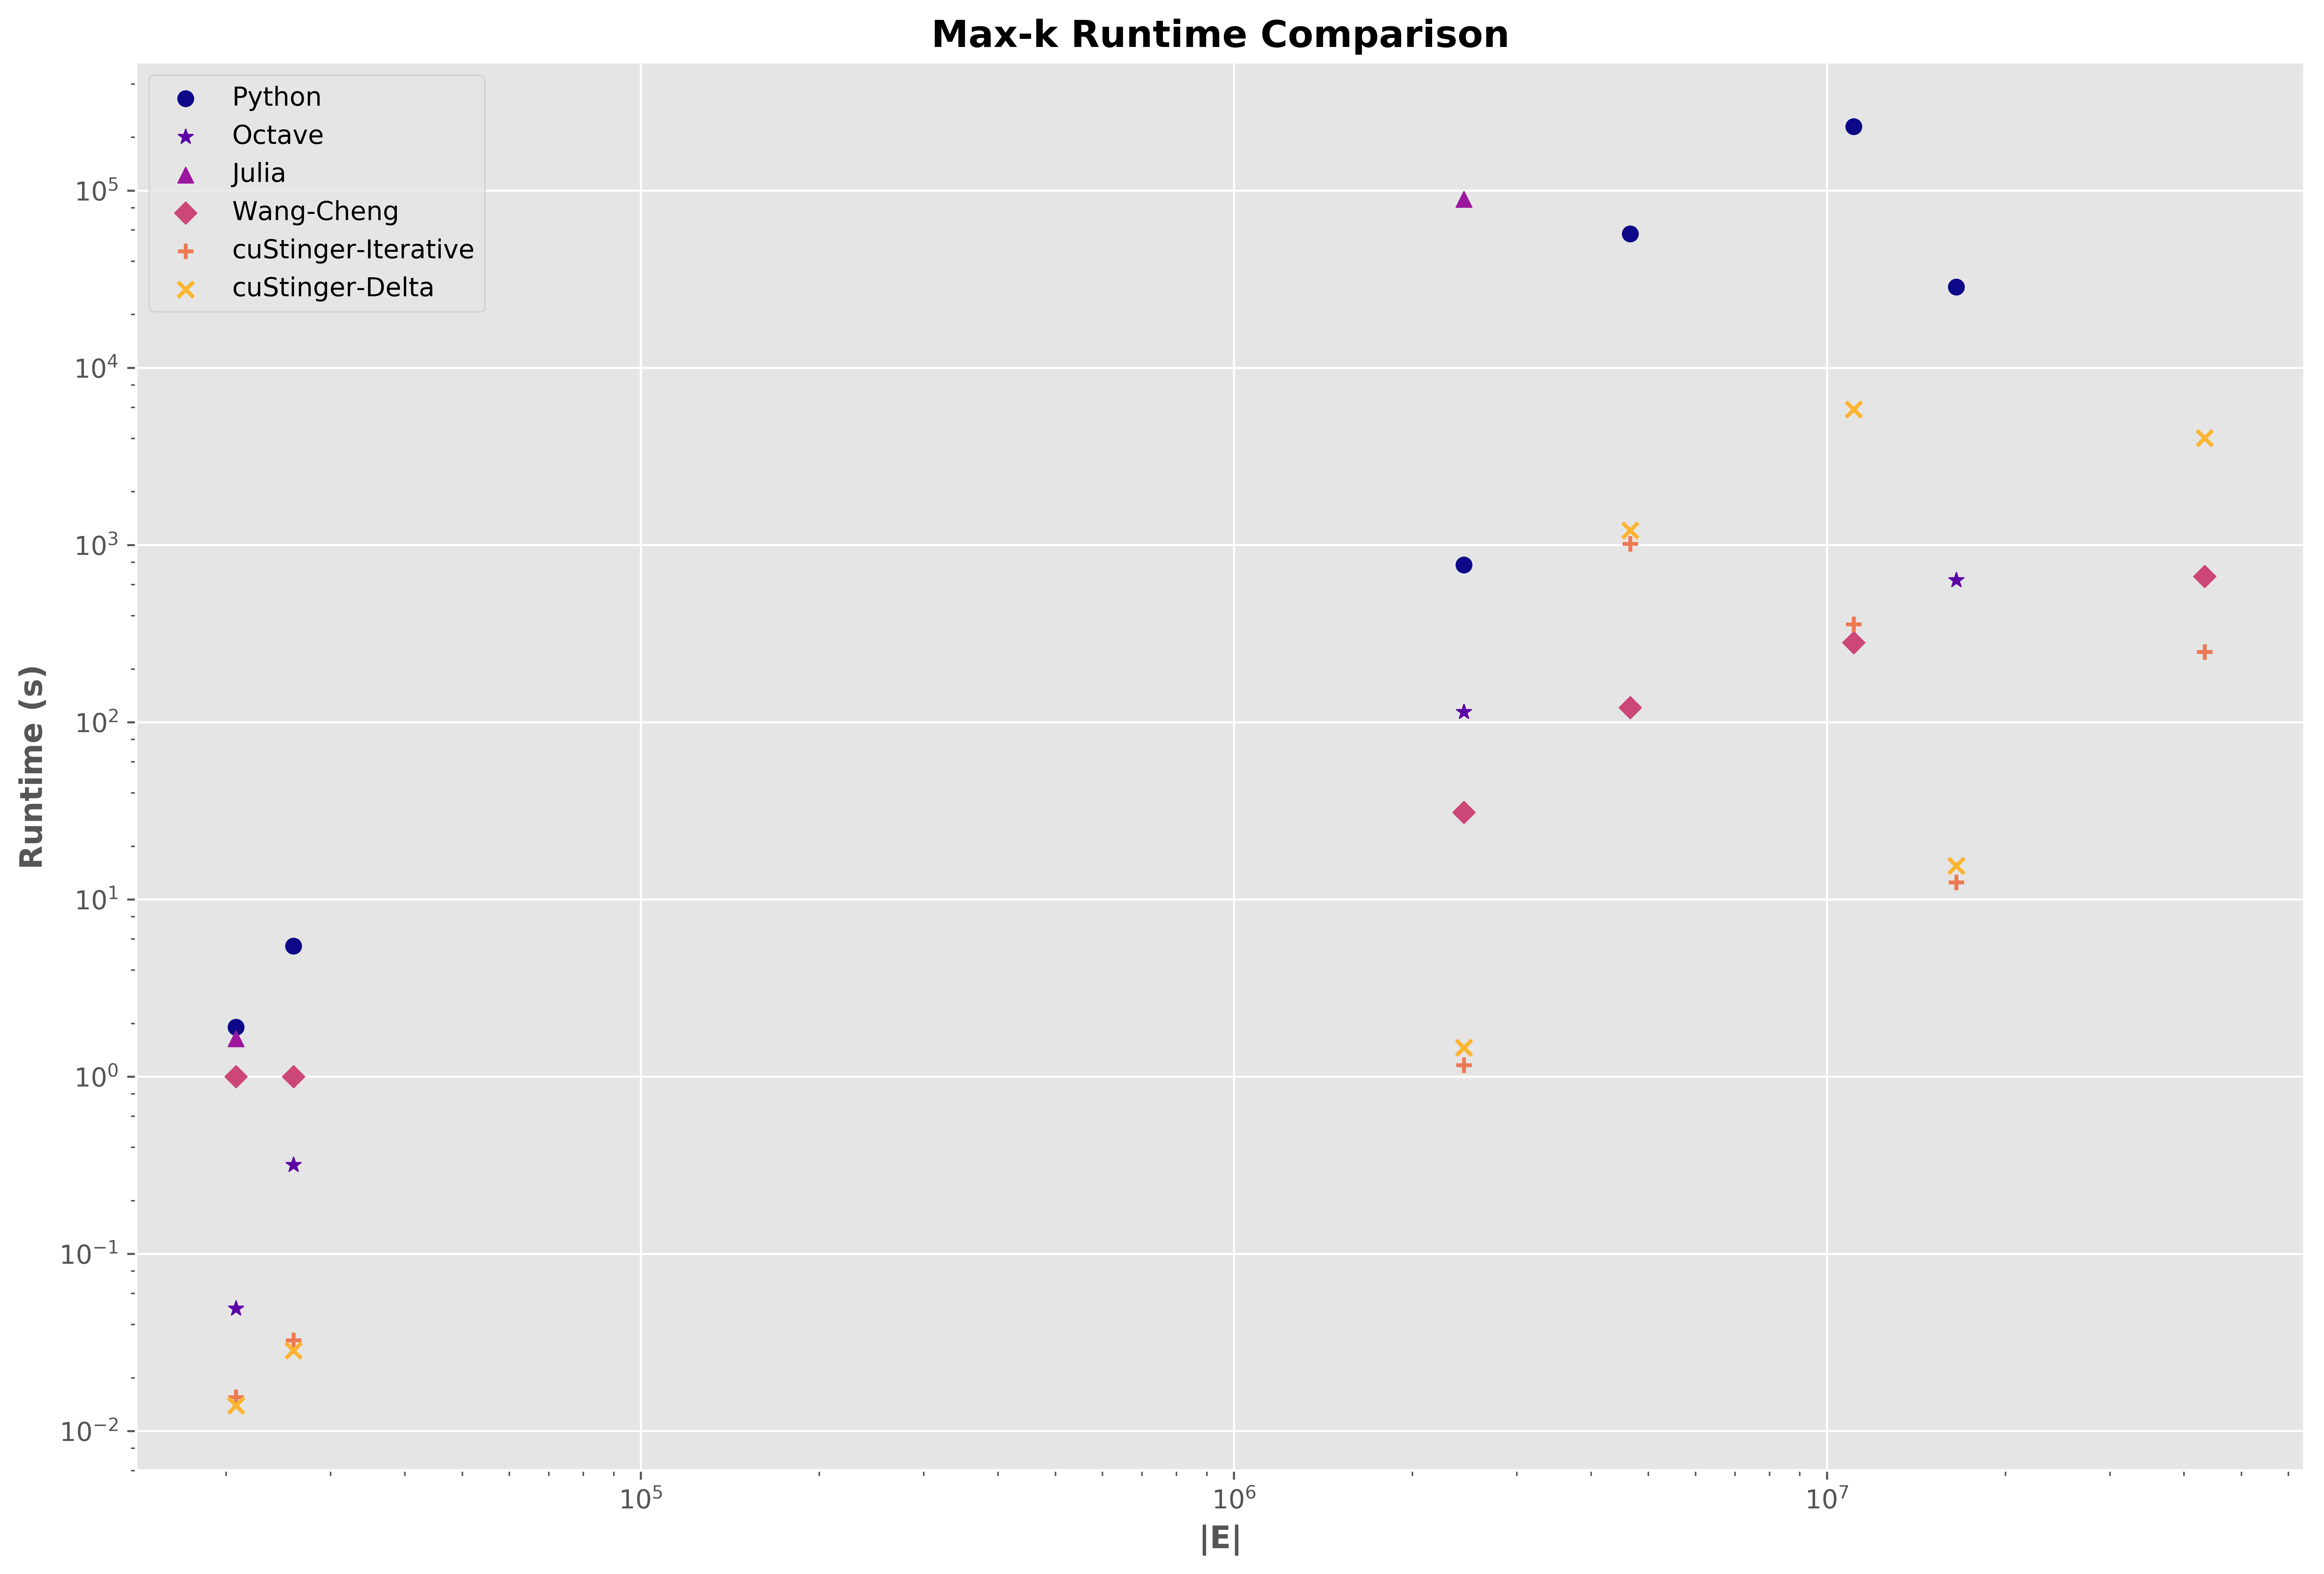

In [197]:
results = ["../results/python-maxk-061617.out",
           "../results/matlab-maxk-061917.out",
           "../results/julia-maxk-061917.out",
           "../results/Wang-Cheng-results.out", 
           "../results/custinger-dynamic-maxk-061317.out", 
          "../results/custinger-static-maxk-061417.out"]
benchmarks = ["Python", "Octave", "Julia", WC, CUS1, CUS2]
graphs = ["p2p-Gnutella08","ca-HepTh","amazon0601","wiki-Talk","as-skitter", "cit-Patents", "soc-LiveJournal1"]
title = "Max-k Runtime Comparison"
saveTo = "../analysis/maxk-scatter.png"
plotKCompareScatter(results, benchmarks, graphs, title, savePath=saveTo)

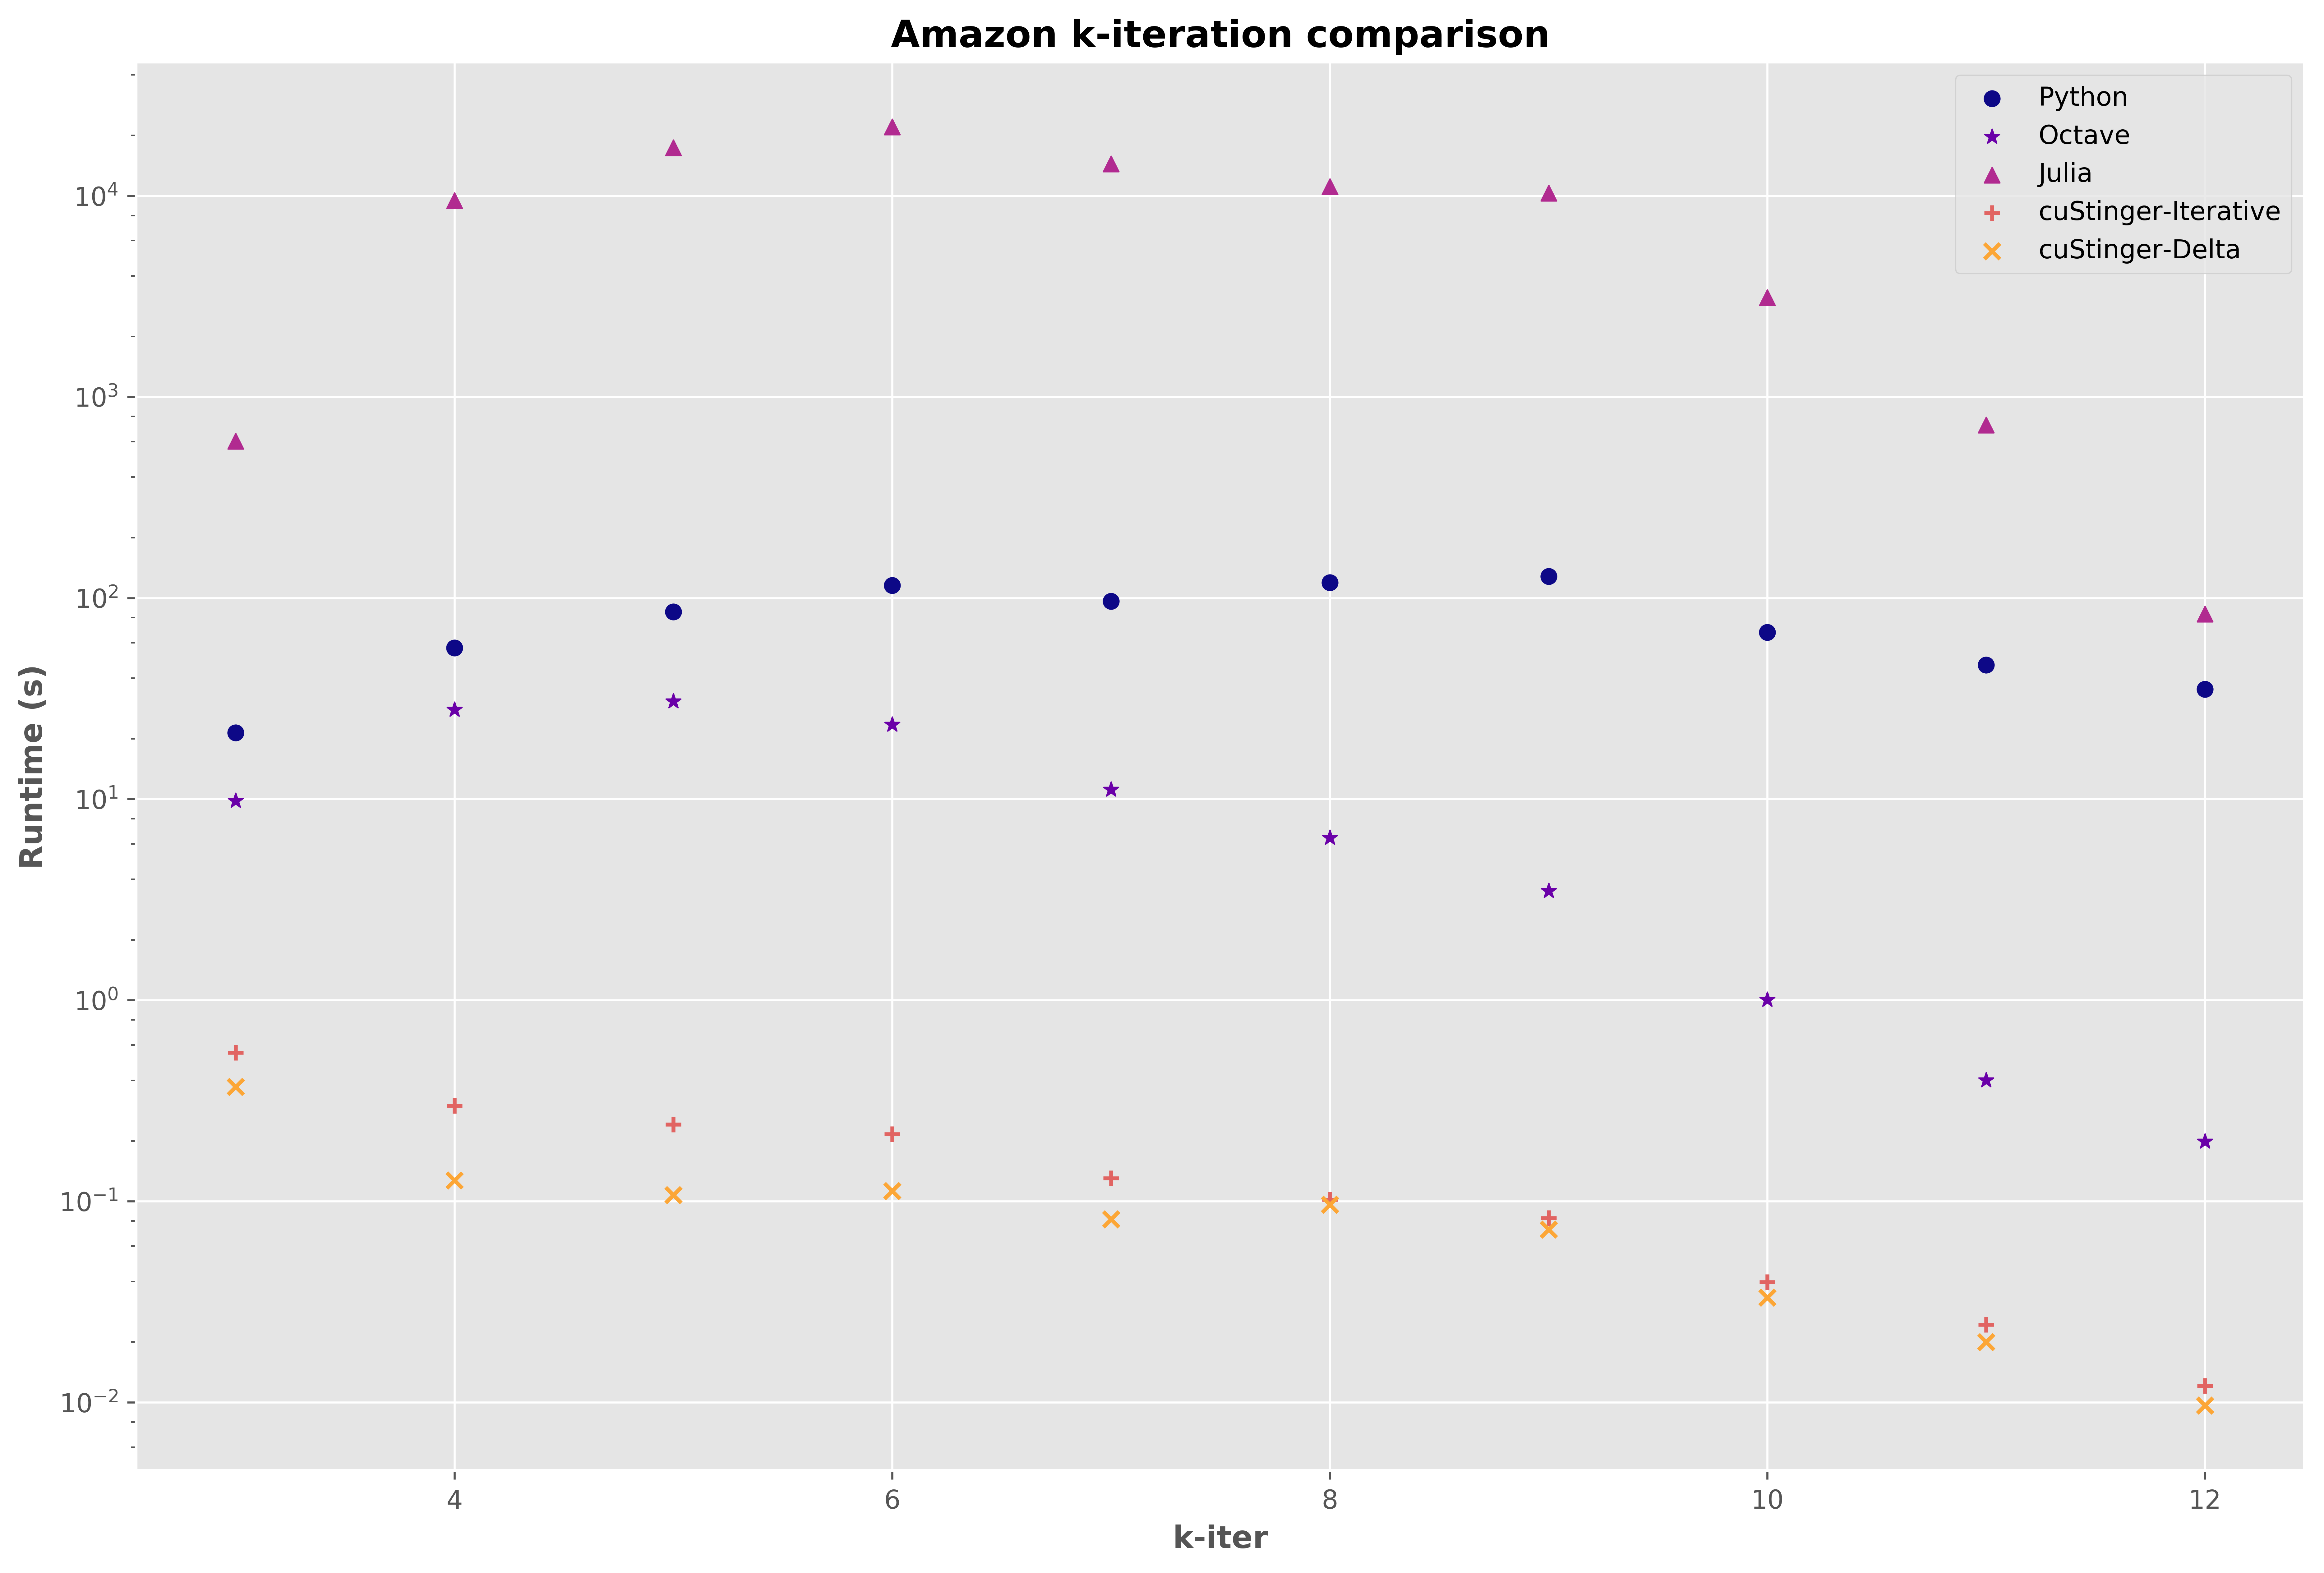

In [204]:
results = ["../results/python-maxk-061617.out",
           "../results/matlab-maxk-061917.out",
           "../results/julia-maxk-061917.out",
           "../results/amazon-maxk-custinger-static-062017.out", 
          "../results/amazon-maxk-custinger-dynamic-062017.out"]
benchmarks = ["Python", "Octave", "Julia", CUS1, CUS2]
graph = "amazon0601"
saveTo = "../analysis/amazon-kIter-scatter.png"
title="Amazon k-iteration comparison"
plotKIterScatter(results, benchmarks, graph, title=title, savePath=saveTo)